In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=250,fontsize=10)

In [4]:
adata = sc.read_h5ad("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Test/Test2_nolog/bin50_A2-3.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 16516 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.obs['arterial_smc'] = (adata.X[:,adata.var_names=='MYH11'] > 1) & (adata.X[:,adata.var_names=='TTN'] == 0)

In [7]:
adata_aec = adata[adata.obs['arterial_smc'] == True]

In [8]:
adata_aec

View of AnnData object with n_obs × n_vars = 219 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
data = adata_aec.obs[['X_coor','Y_coor']]
linkage_data = linkage(data, method='average', metric='euclidean')

In [10]:
temp = dendrogram(linkage_data,no_plot=True)

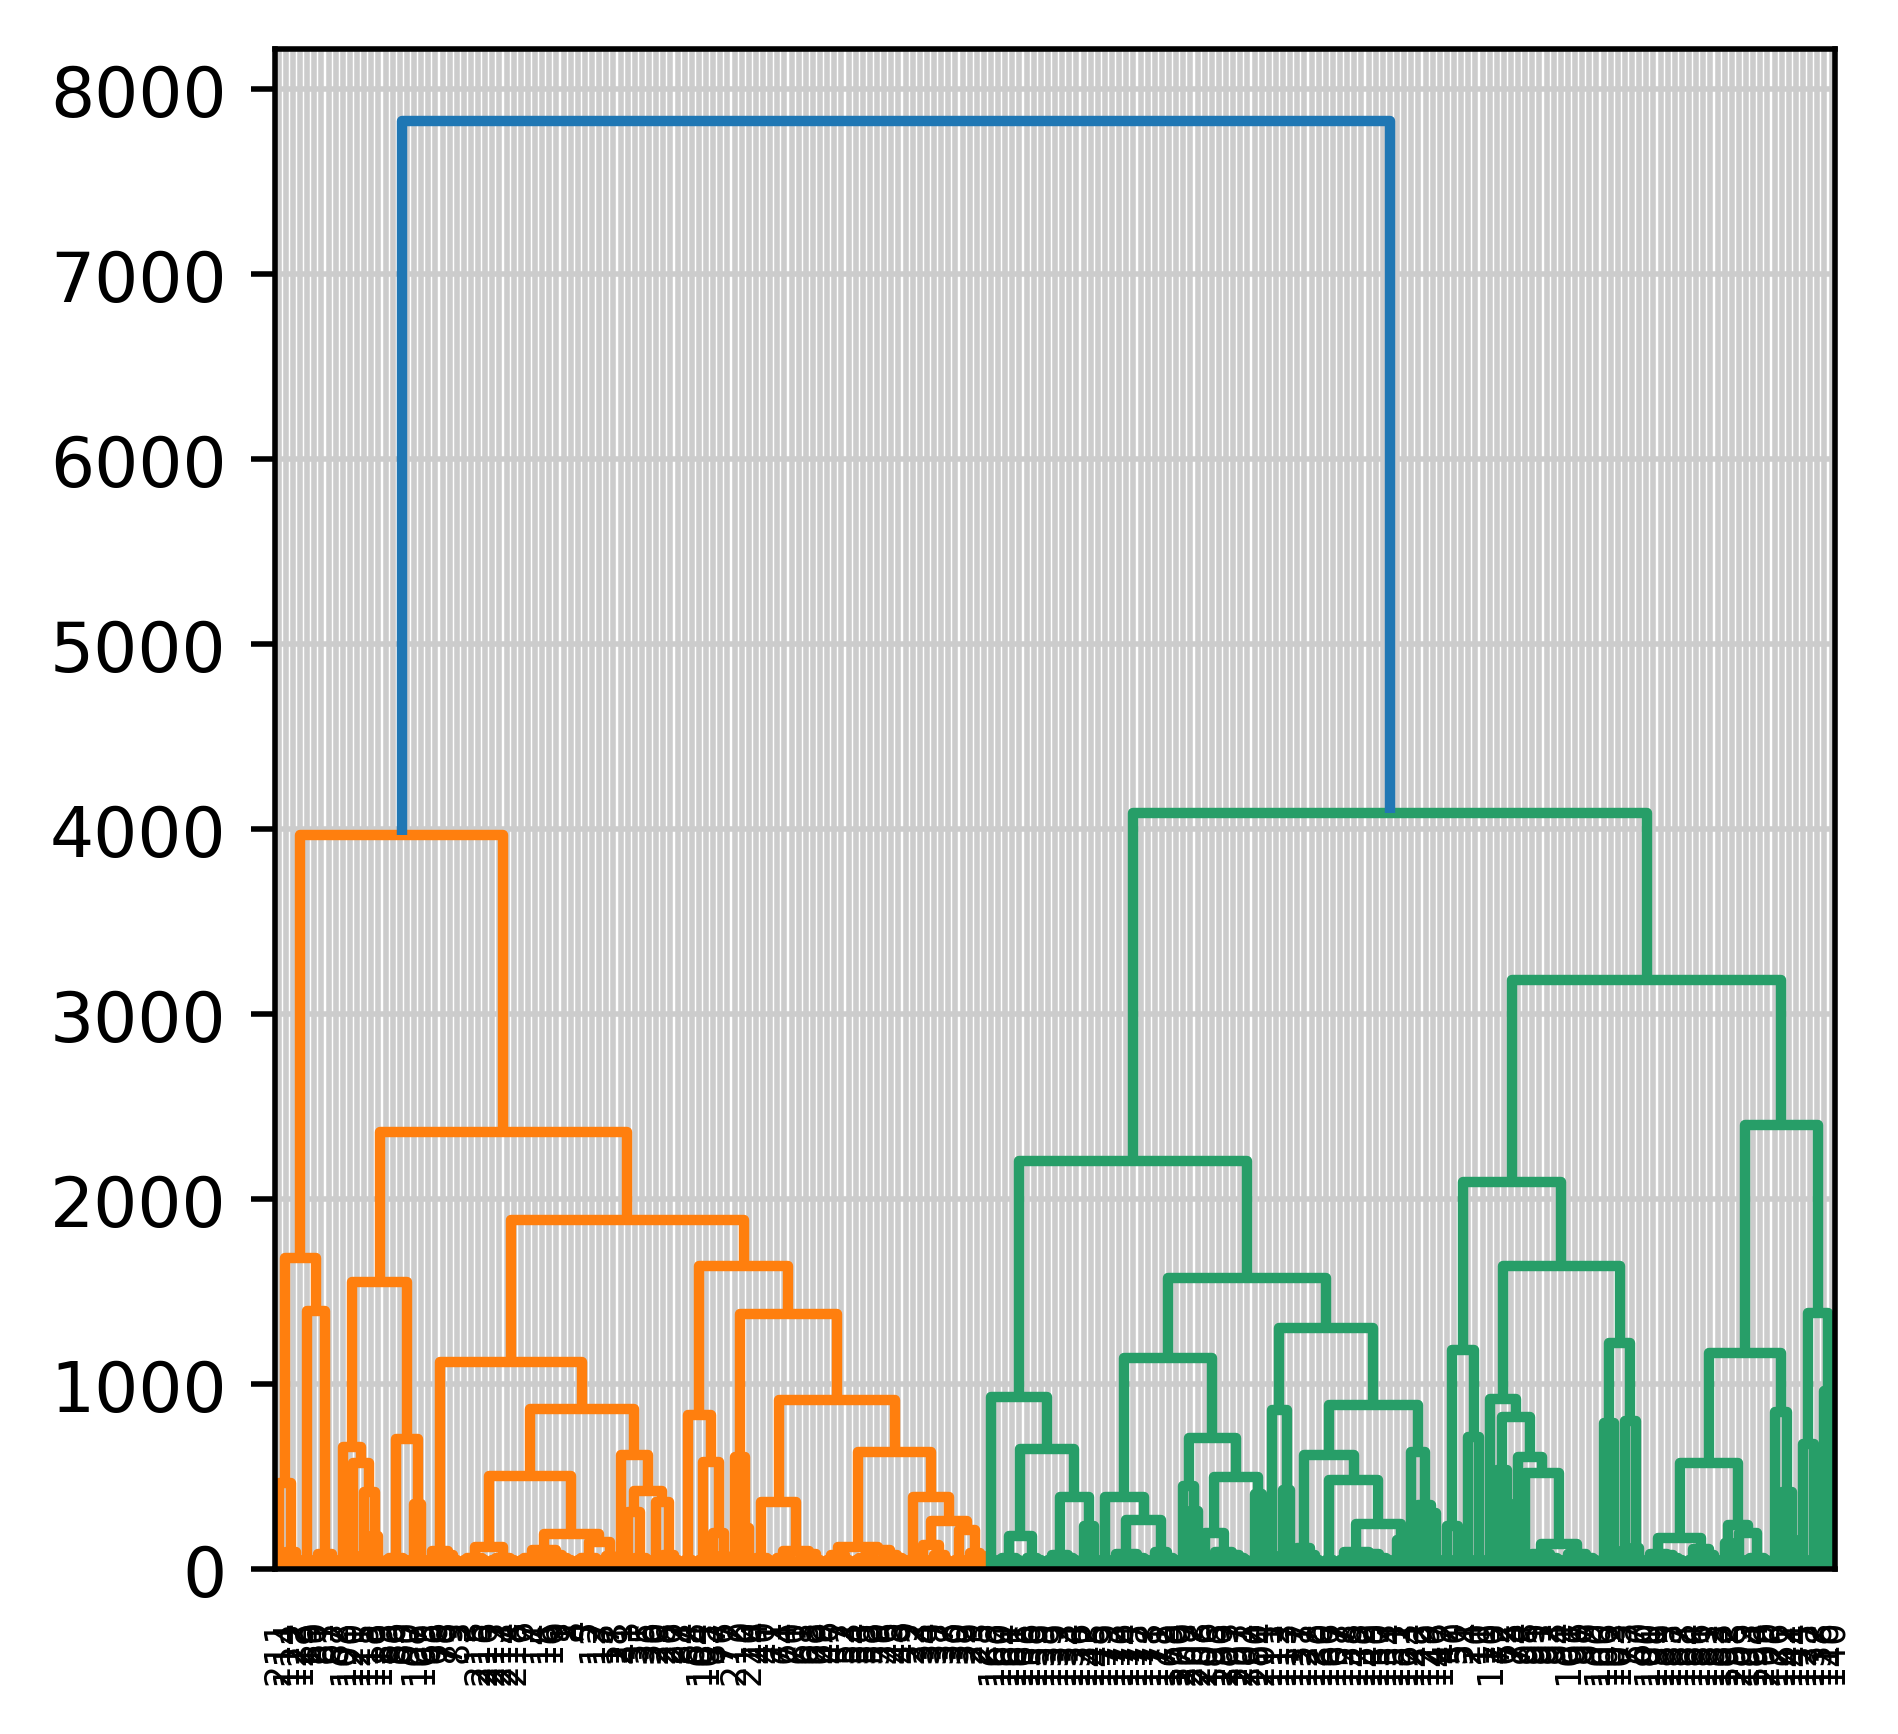

In [11]:
dendrogram(linkage_data)
plt.show()

In [12]:
adata_aec

View of AnnData object with n_obs × n_vars = 219 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
# adjust n_clusters to relevant number of vessels
hierarchical_cluster = AgglomerativeClustering(n_clusters=99, affinity='euclidean', linkage='single')

In [14]:
labels = hierarchical_cluster.fit_predict(data) 
print(labels)

[74 46 32 32 46 46 46 46 46 46 17 17 46 46 46 46 46  3  3 63 59 52 70  1
 79  1 35 35 35  1 41 19 41 22 22 19 19 44 44 44 34 34 97 55 34 26 26 26
 26 26 37 37 26 26 26 26 26 68 26 26 89 51 85 51 51 25 25  2 51 51 51 51
 57 67 65 56  0  0 25 25  2  2  2 25 43 12 12 54 43 12 12 20 20 20 20 20
 20 20 69 20 20 20 84 92 76 76 60 53 83 58 75 88 95 73 94 28 71 81 77 36
 80 98  7  7 87 91 96 15 15 64 15 48 50 14 14 14 14 11 11 14 90 47 31  8
 39  8  5  5 38 38 38 86 38 38 38  9  9 38 38  9 10 10 61 82 10 10 13 13
 49 18 18 23 18 21 21 21 21 21 21 33 93  6  6  6  6  6  6  6  6  6  6  6
 66  4  4 16 16 16 42  4  4 16 16 16 45 62 40 24 30 27 29 72 78 32 32 32
 32 32 32]


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [15]:
adata_aec.obs['SMC_clusters'] = labels
adata_aec.obs['SMC_clusters'] = adata_aec.obs['SMC_clusters'].astype('category')

/var/tmp/pbs.7737892.pbs/ipykernel_2736192/1883412233.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_aec.obs['SMC_clusters'] = labels
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [16]:
adata_aec.obs['SMC_clusters'].value_counts()

46    12
26    12
6     11
20    10
32     8
      ..
61     1
62     1
63     1
64     1
98     1
Name: SMC_clusters, Length: 99, dtype: int64

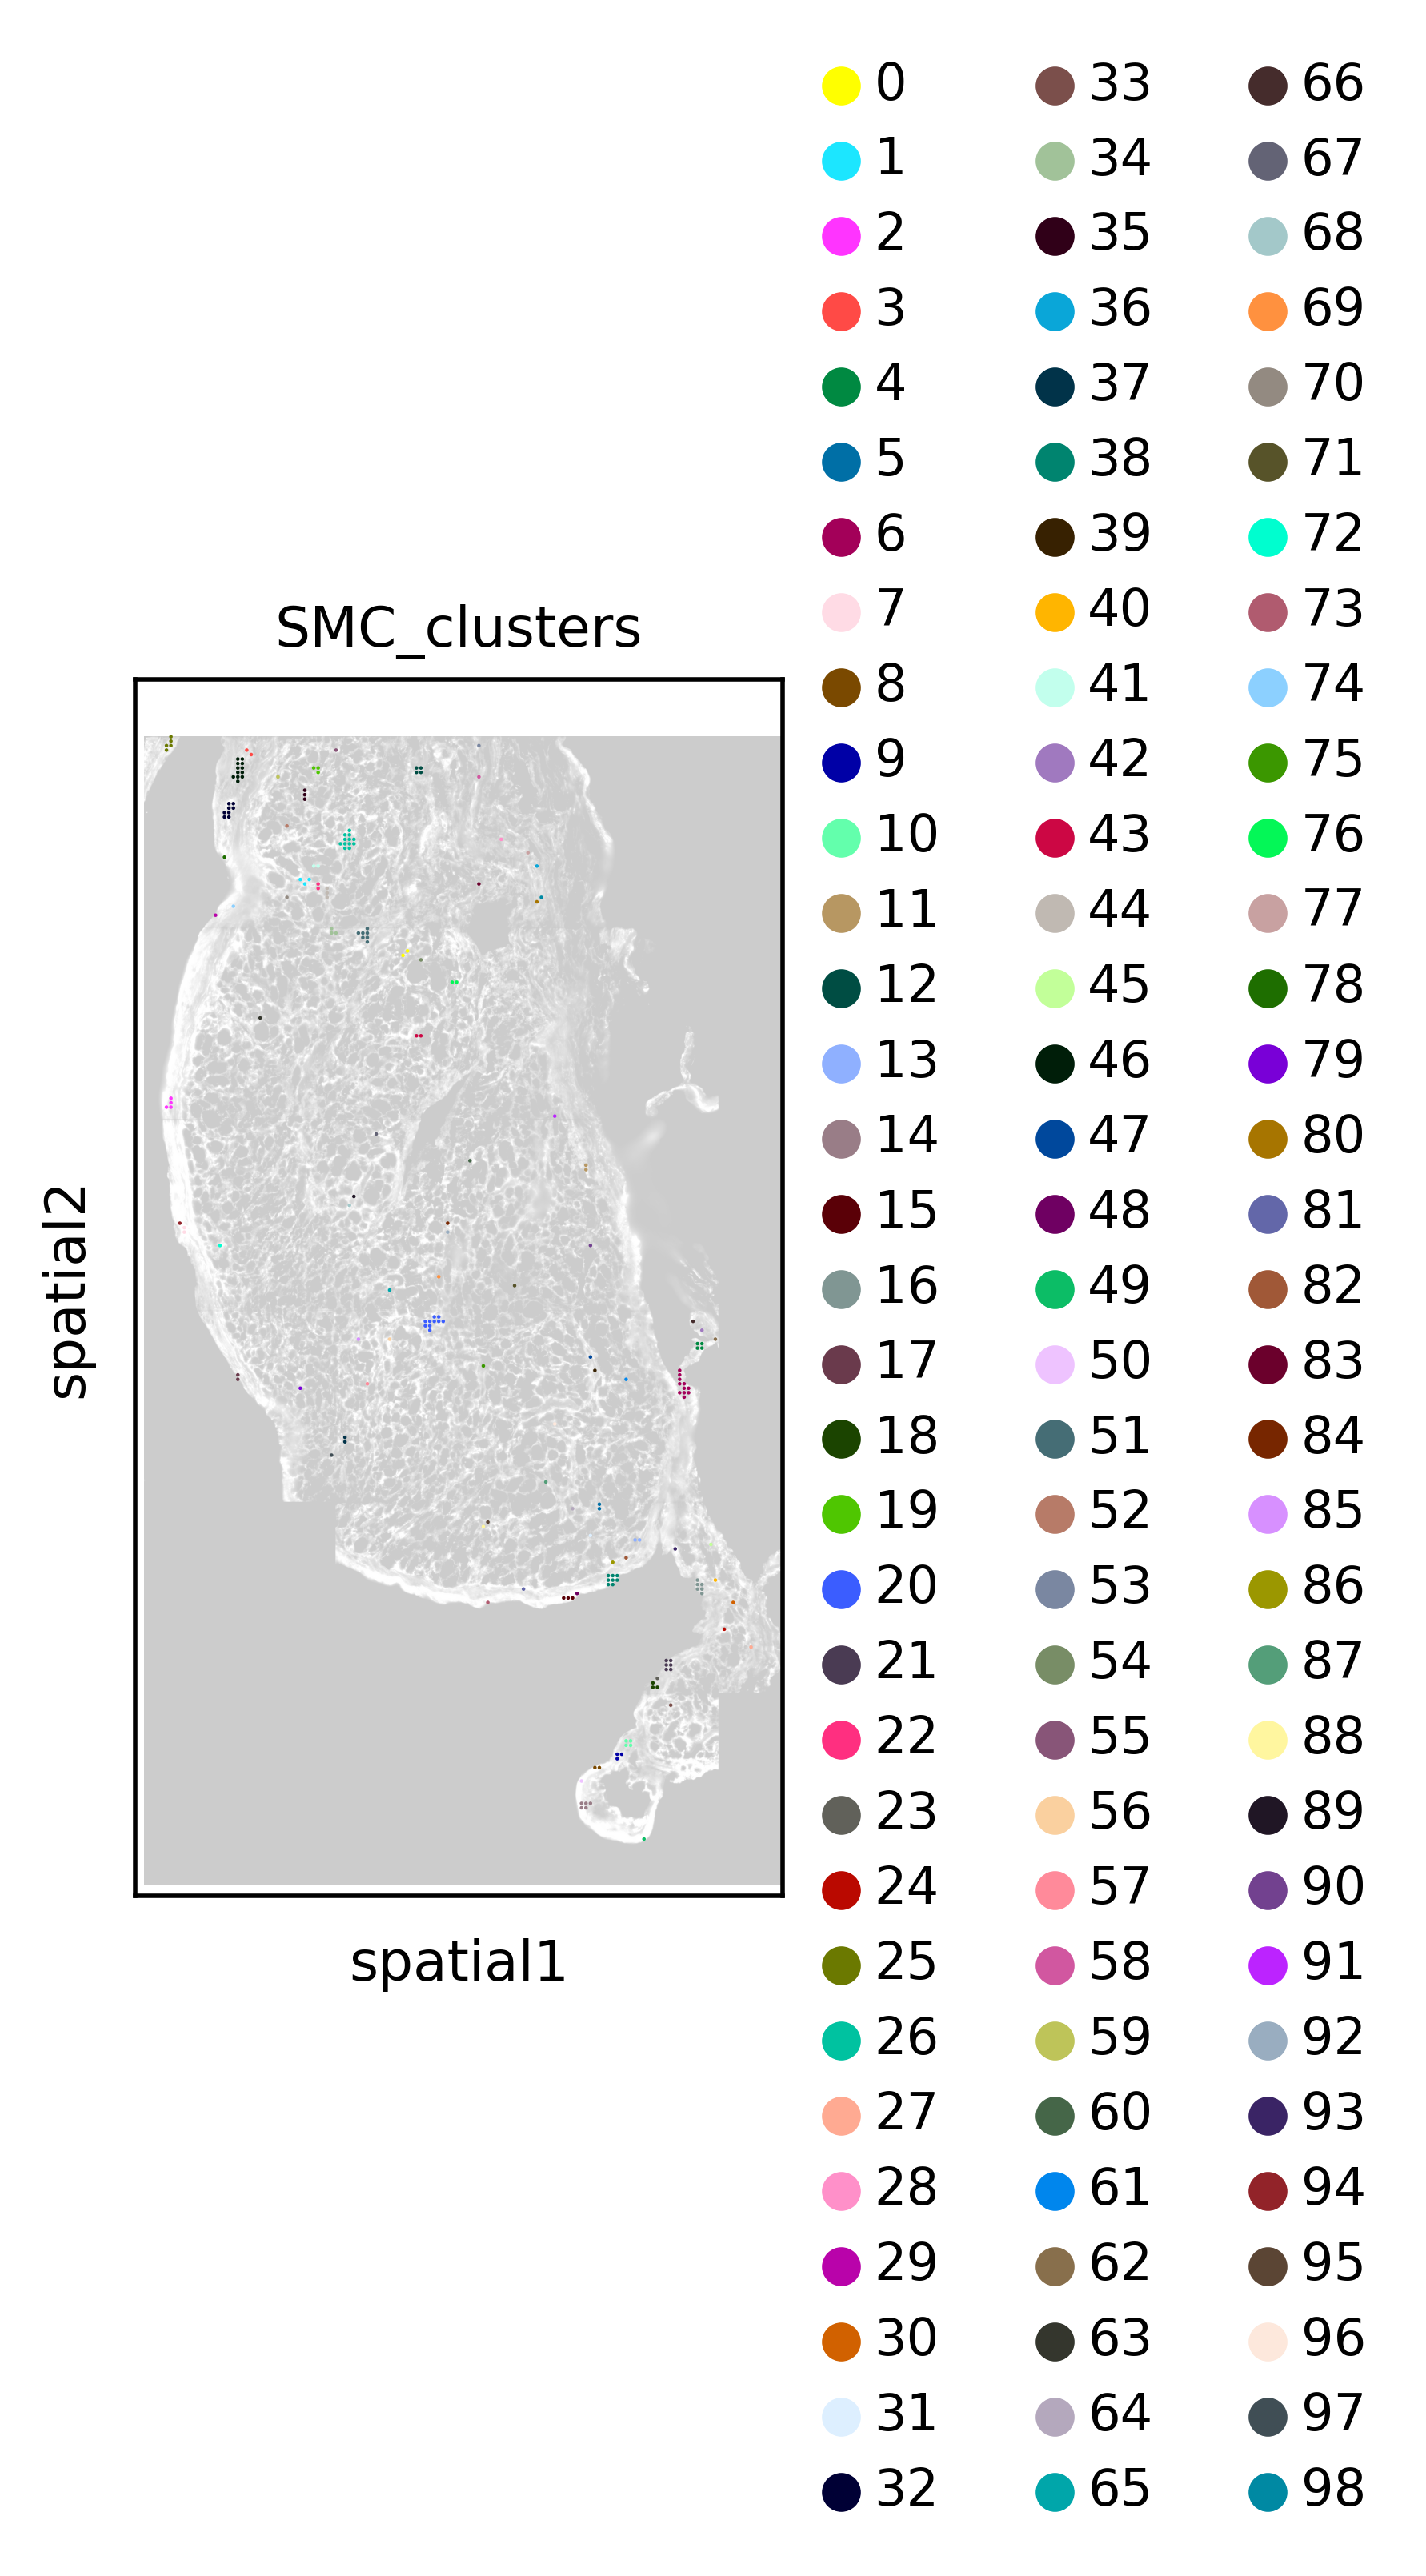

In [17]:
sc.pl.spatial(adata_aec, color="SMC_clusters",img_key='WGA',size=8, alpha_img = 0.2)

In [18]:
# subset for clusters > 5 bins
adata_aec.obs['SMC_clusters'].value_counts()[adata_aec.obs['SMC_clusters'].value_counts() > 5].index.tolist()

[46, 26, 6, 20, 32, 38, 51, 16, 21]

In [19]:
adata_aec_subset = adata_aec[adata_aec.obs.SMC_clusters.isin(adata_aec.obs['SMC_clusters'].value_counts()[adata_aec.obs['SMC_clusters'].value_counts() > 5].index.tolist())]

In [20]:
adata_aec_subset.obs.SMC_clusters = adata_aec_subset.obs.SMC_clusters.astype(str).astype('category')

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [21]:
adata_aec_subset

AnnData object with n_obs × n_vars = 80 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc', 'SMC_clusters'
    var: 'Genes'
    uns: 'spatial', 'SMC_clusters_colors'
    obsm: 'spatial'

In [22]:
del adata_aec_subset.uns['SMC_clusters_colors']

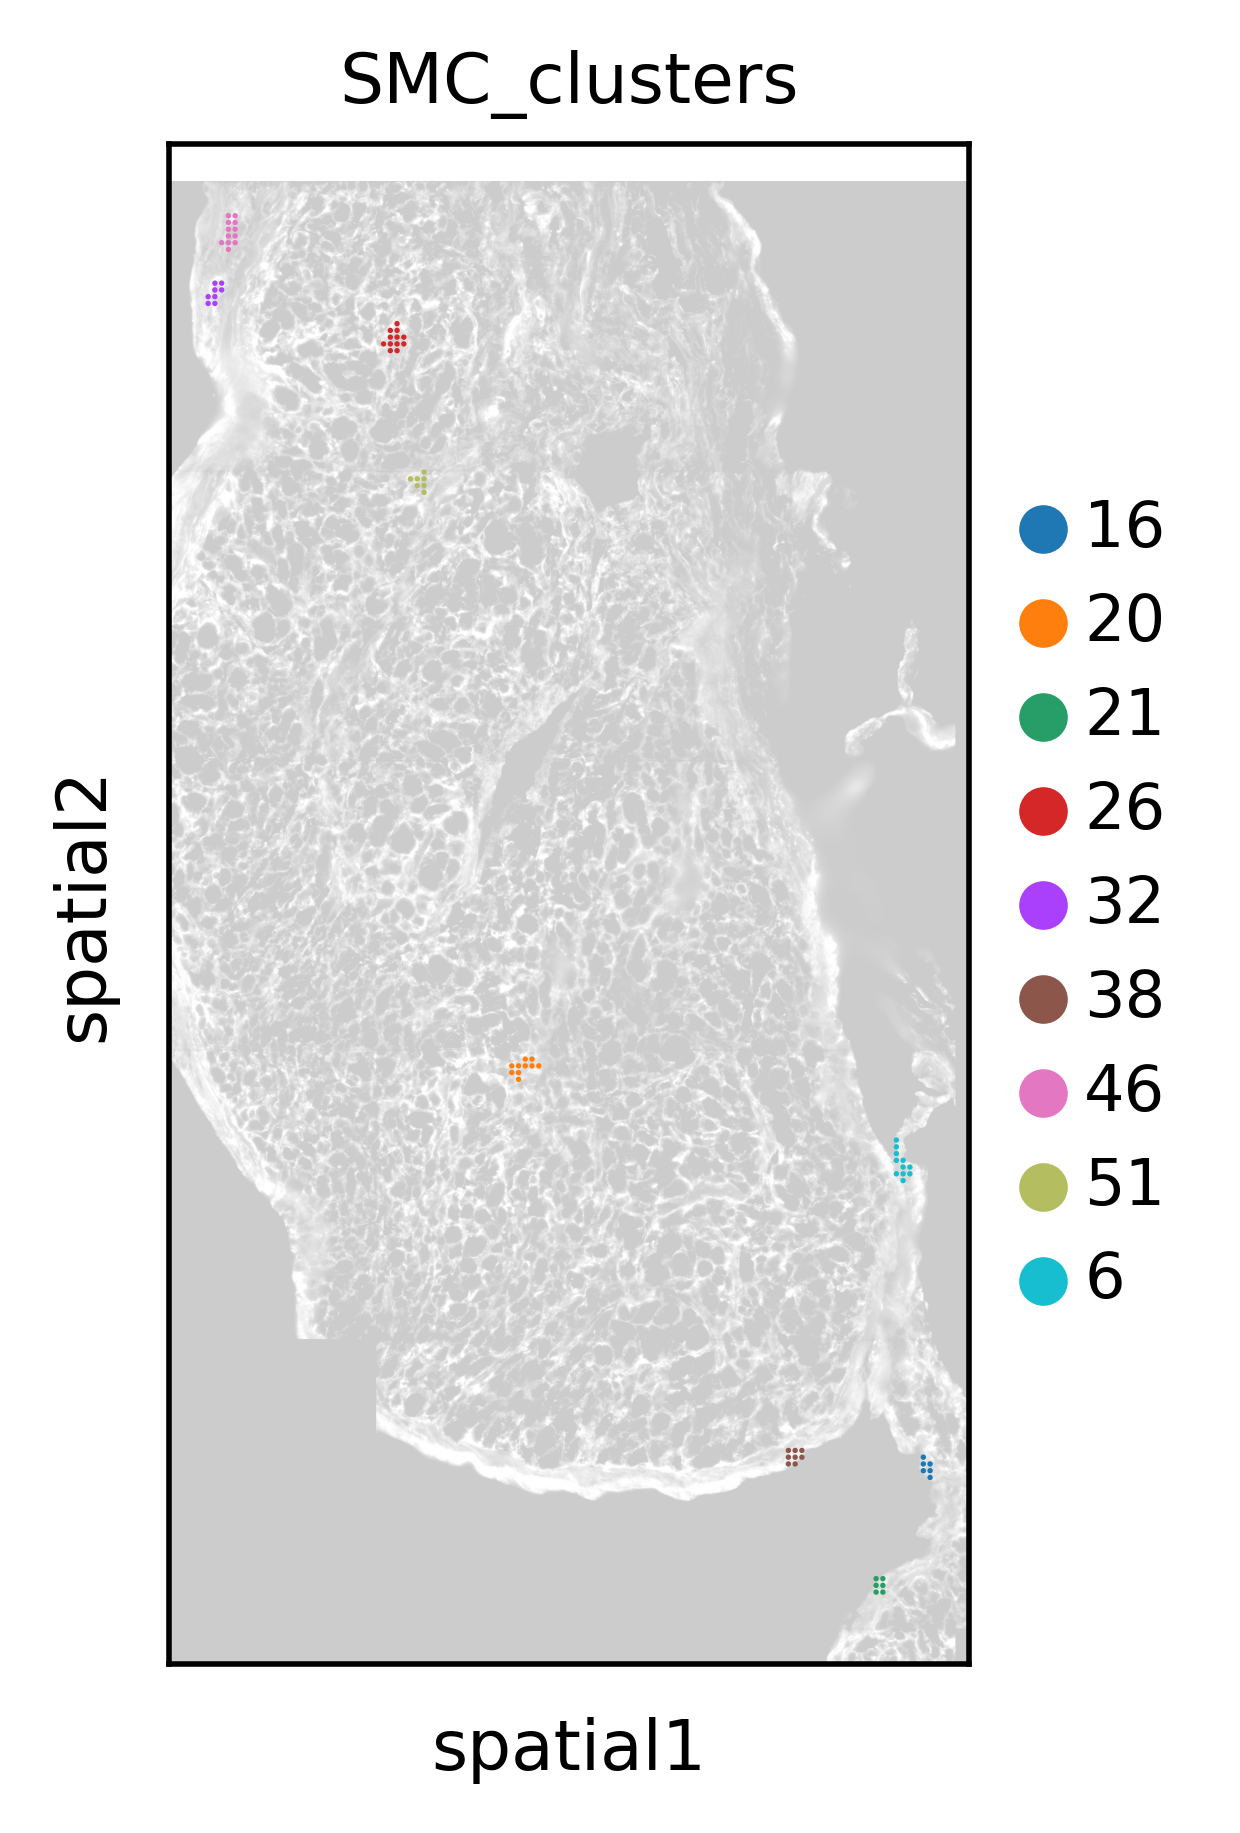

In [23]:
sc.pl.spatial(adata_aec_subset,
              color="SMC_clusters",img_key='WGA',size=8, alpha_img = 0.2)

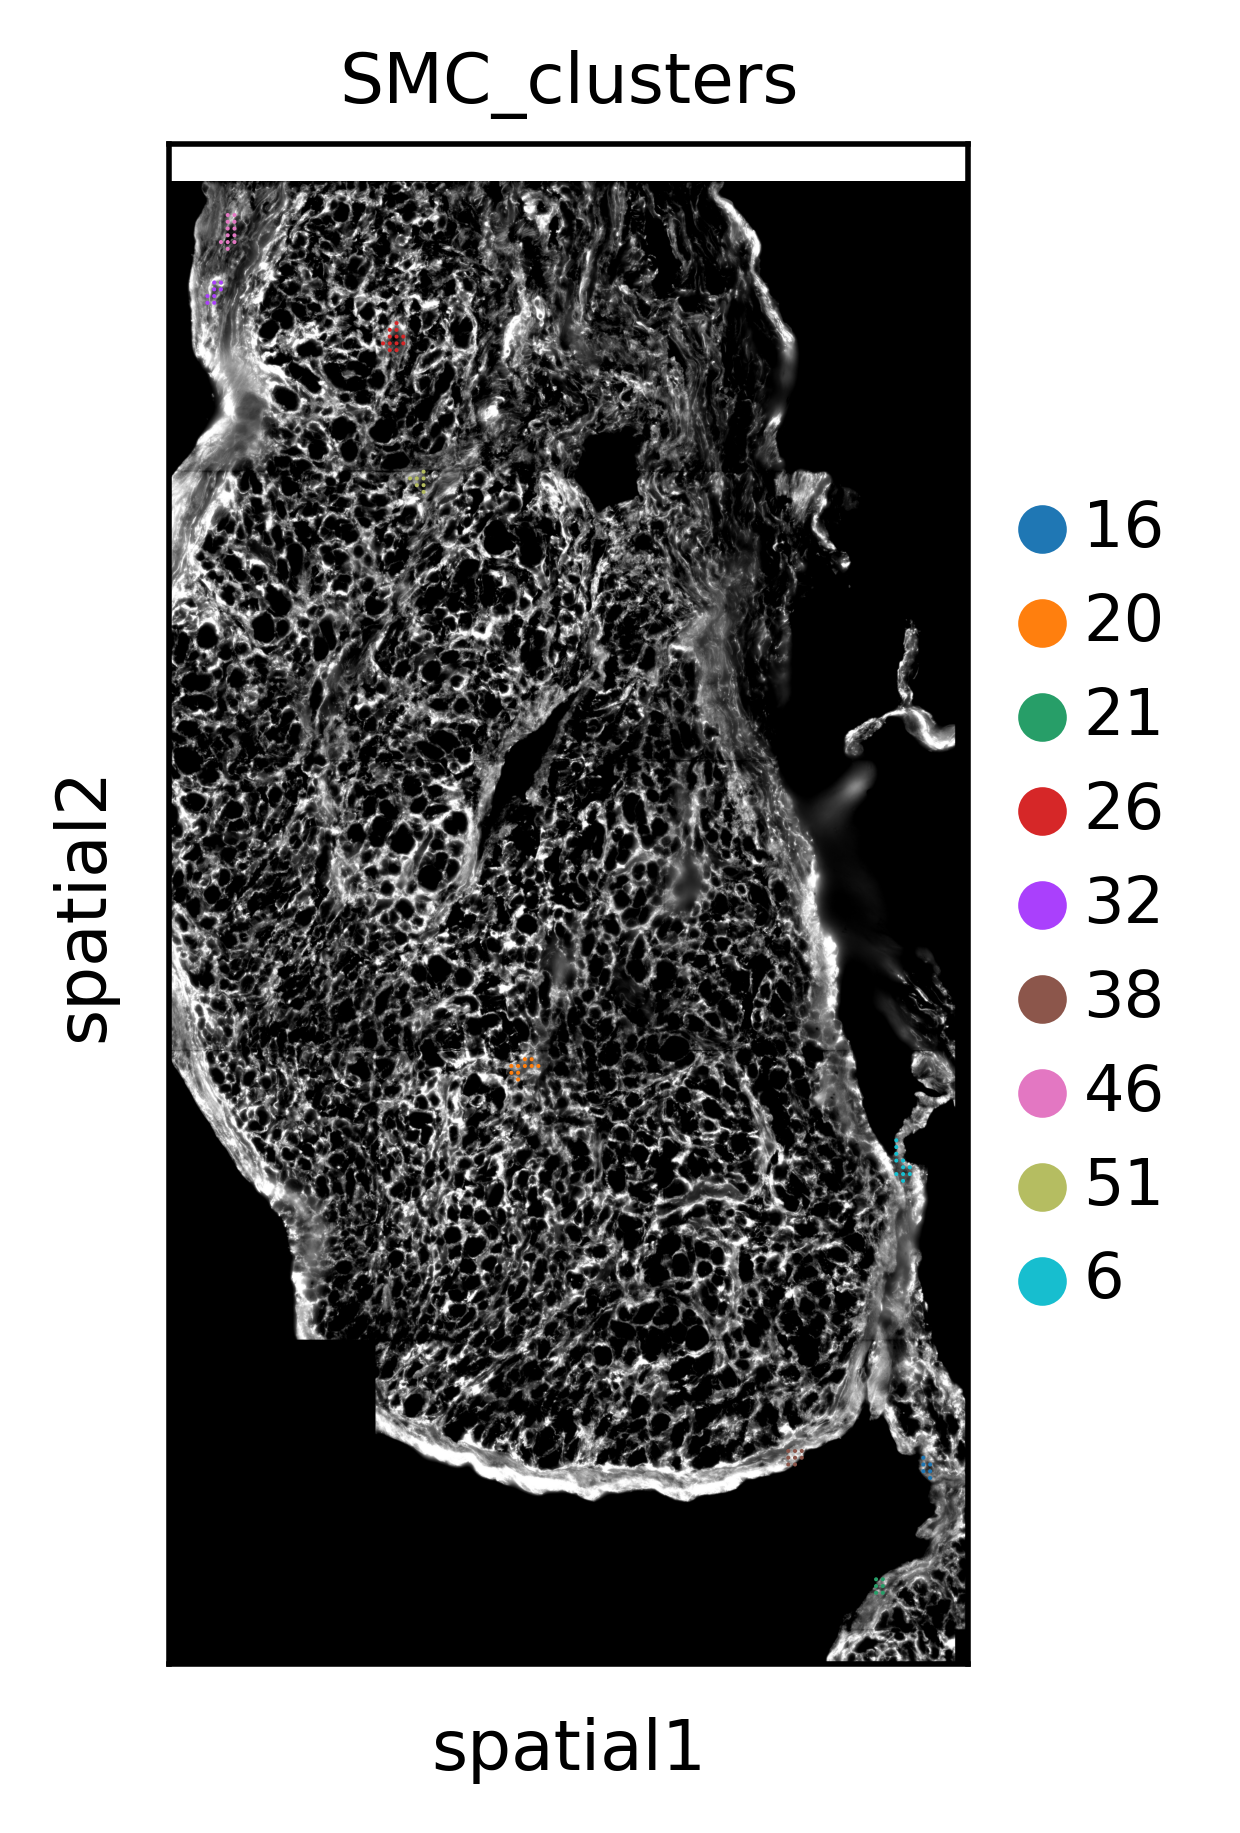

In [24]:
sc.pl.spatial(adata_aec_subset,
              color="SMC_clusters",img_key='WGA',size=6)

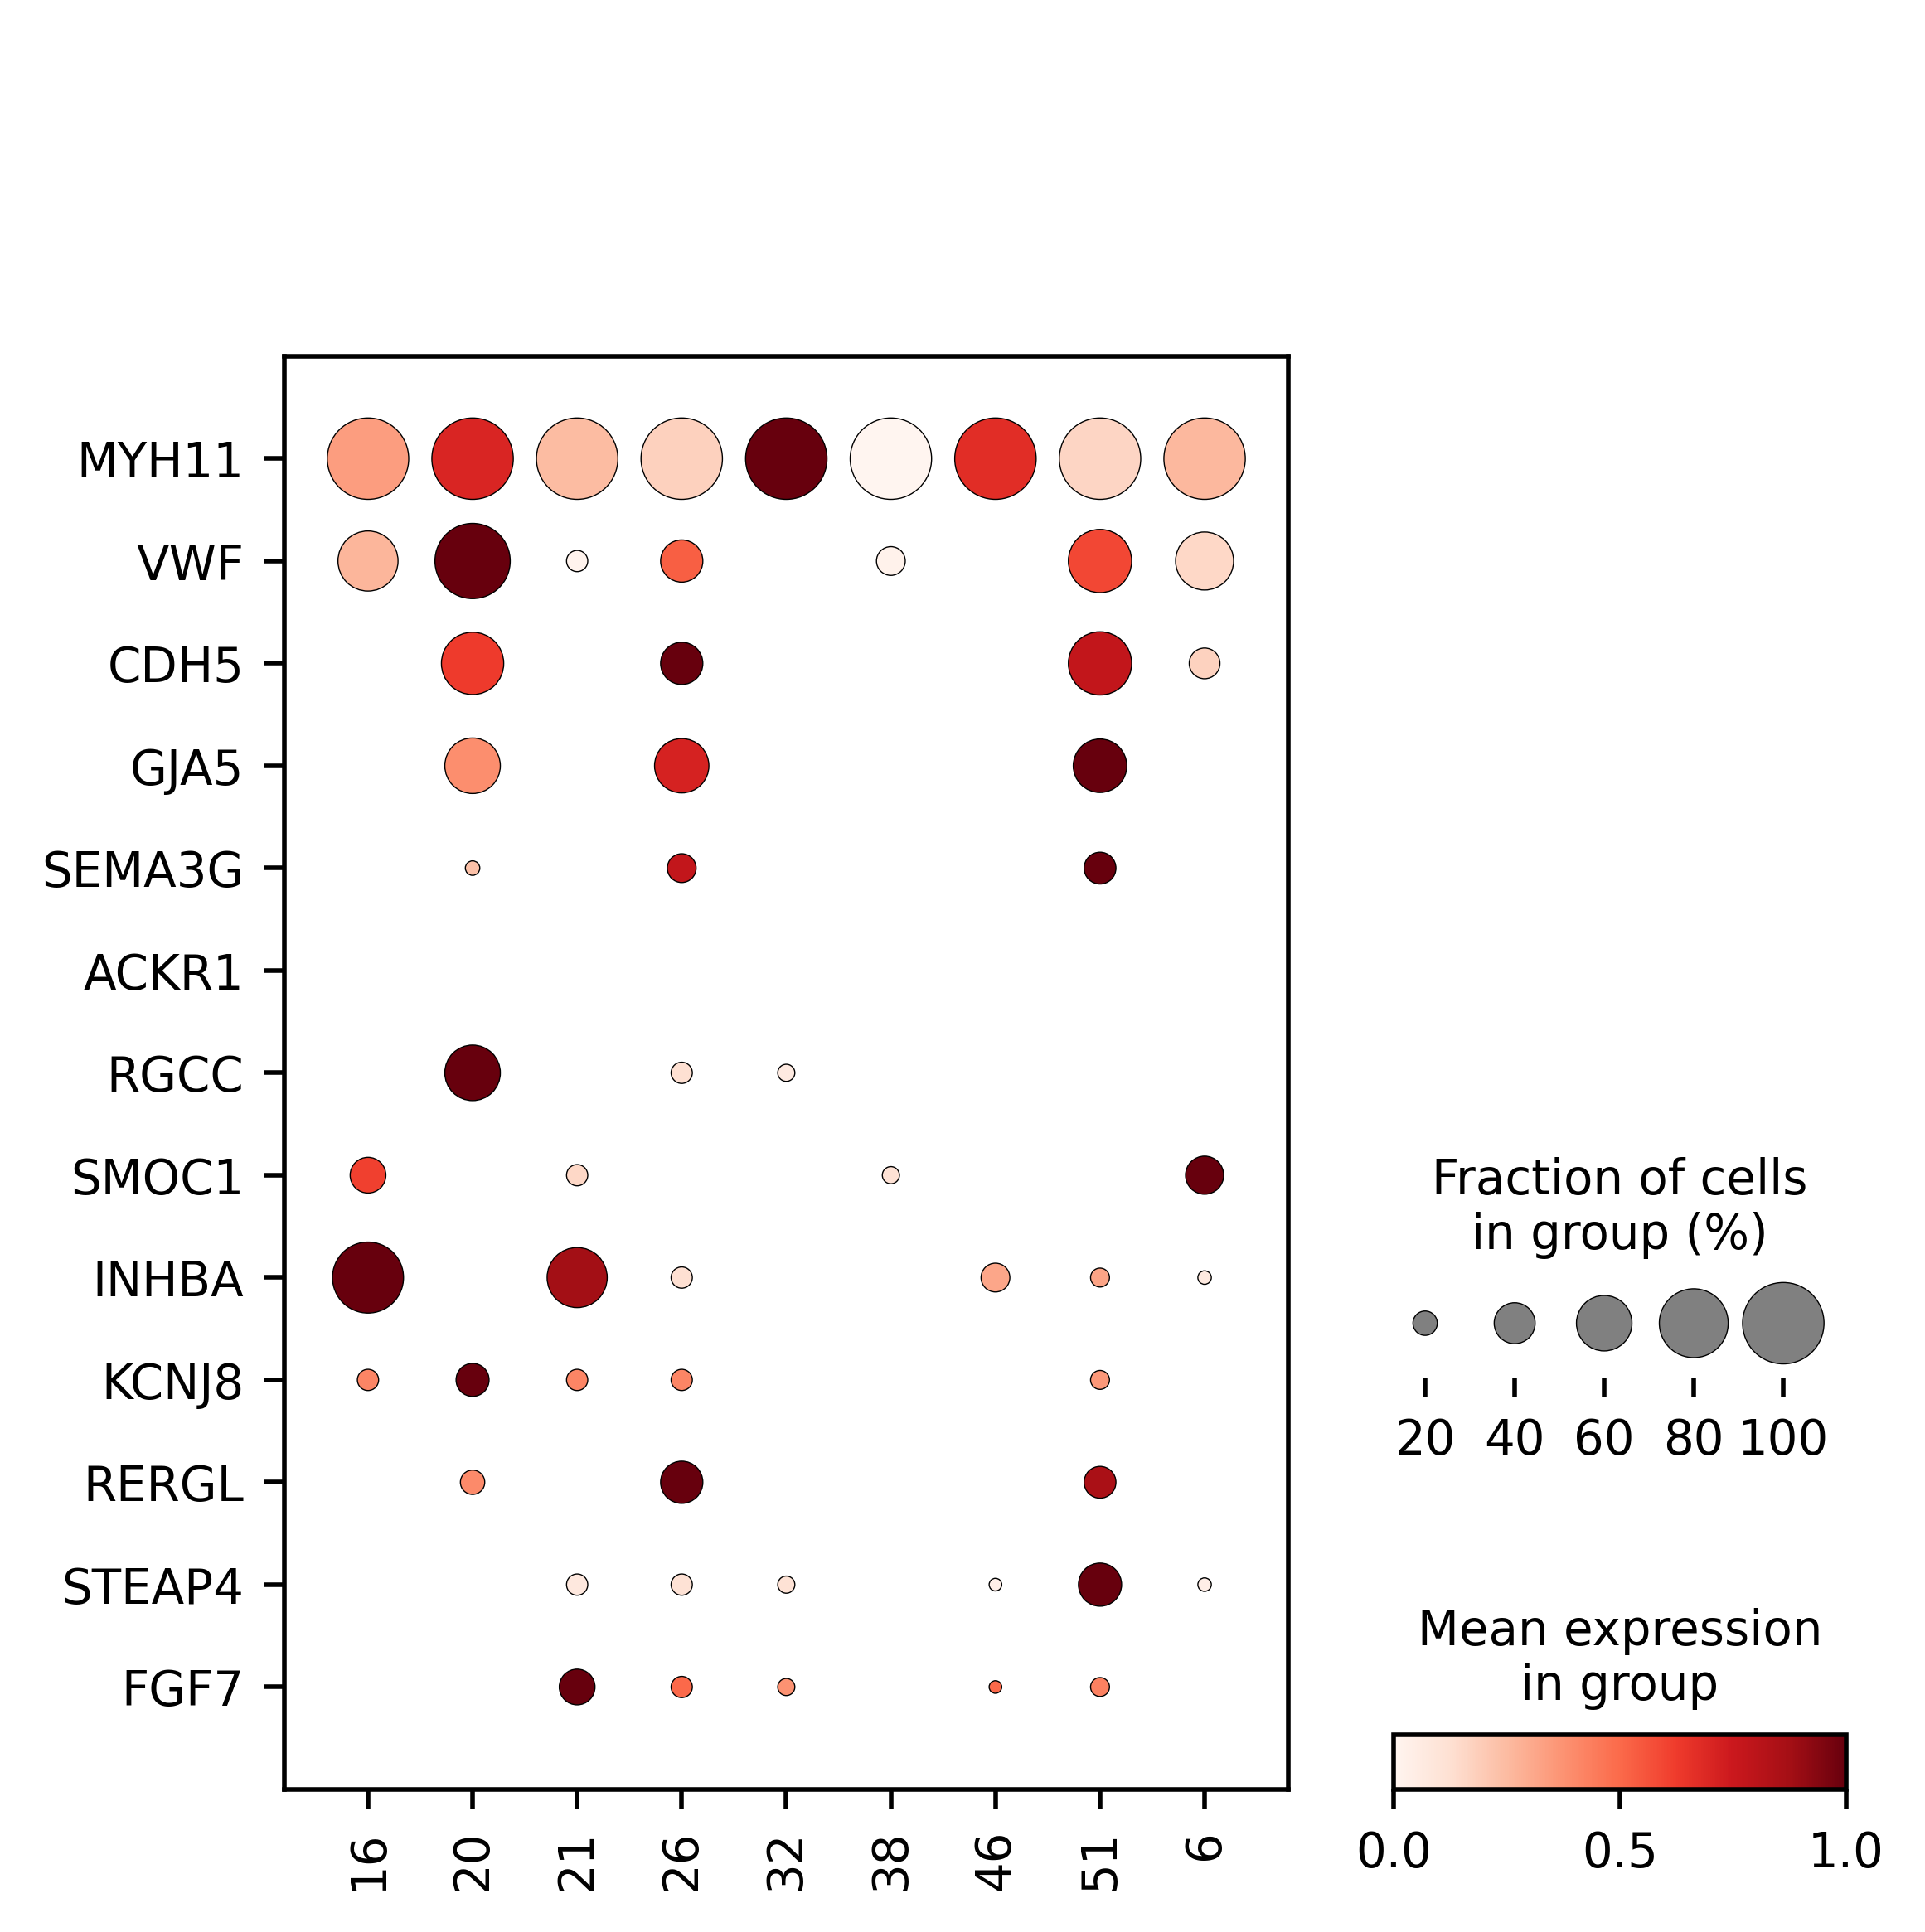

In [25]:
markers = ["MYH11","VWF","CDH5","GJA5","SEMA3G","ACKR1","RGCC","SMOC1","INHBA","KCNJ8","RERGL","STEAP4","FGF7"]
sc.pl.dotplot(adata_aec_subset, markers, "SMC_clusters", cmap = 'Reds', swap_axes = True, standard_scale = 'var')

In [26]:
# add gene percentage expressed to dataframe

In [27]:
adata_aec_subset.obs['RERGL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='RERGL'] > 0)

In [28]:
adata_aec_subset.obs['STEAP4_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='STEAP4'] > 0)

In [29]:
adata_aec_subset.obs['FGF7_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='FGF7'] > 0)

In [30]:
adata_aec_subset.obs['KCNJ8_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='KCNJ8'] > 0)

In [31]:
adata_aec_subset.obs['AGT_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='AGT'] > 0)

In [32]:
adata_aec_subset.obs['STEAP4_FGF7_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='STEAP4'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='FGF7'] > 0)

In [33]:
adata_aec_subset.obs['STEAP4_KCNJ8_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='STEAP4'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='KCNJ8'] > 0)

In [34]:
adata_aec_subset

AnnData object with n_obs × n_vars = 80 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc', 'SMC_clusters', 'RERGL_percent', 'STEAP4_percent', 'FGF7_percent', 'KCNJ8_percent', 'AGT_percent', 'STEAP4_FGF7_percent', 'STEAP4_KCNJ8_percent'
    var: 'Genes'
    uns: 'spatial', 'SMC_clusters_colors'
    obsm: 'spatial'

In [35]:
results = adata_aec_subset.obs[['RERGL_percent','STEAP4_percent','FGF7_percent','KCNJ8_percent','AGT_percent','STEAP4_FGF7_percent','STEAP4_KCNJ8_percent','SMC_clusters']].groupby('SMC_clusters').mean()

In [36]:
results

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
16                 0.000000        0.000000      0.000000       0.166667   
20                 0.200000        0.000000      0.000000       0.300000   
21                 0.000000        0.166667      0.333333       0.166667   
26                 0.416667        0.166667      0.166667       0.166667   
32                 0.000000        0.125000      0.125000       0.000000   
38                 0.000000        0.000000      0.000000       0.000000   
46                 0.000000        0.083333      0.083333       0.000000   
51                 0.285714        0.428571      0.142857       0.142857   
6                  0.000000        0.090909      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  
SMC_clusters                                                          
16               0.333333             0.000000                   0.0  
20               0.700000             0.000000                   0.0  
21               0.000000             0.000000                   0.0  
26               0.750000             0.000000                   0.0  
32               0.000000             0.125000                   0.0  
38               0.125000             0.000000                   0.0  
46               0.166667             0.000000                   0.0  
51               0.571429             0.142857                   0.0  
6                0.000000             0.000000                   0.0

In [37]:
matrix=pd.DataFrame(adata_aec_subset.X,columns=adata_aec_subset.raw.var.index,index=adata_aec_subset.obs.index)

In [38]:
matrix["SMC_clusters"] = adata_aec_subset.obs["SMC_clusters"]

In [39]:
matrix2 = matrix.replace(0, np.NaN)

In [40]:
df_mean_nonzero =matrix2.groupby("SMC_clusters").mean()

In [41]:
df_mean_nonzero[["RERGL","STEAP4","FGF7","AGT","KCNJ8","SEMA3G","ACKR1","RGCC","SMOC1"]]

Genes         RERGL  STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
16              NaN     NaN   NaN  1.000000  1.000000       NaN    NaN   
20              1.0     NaN   NaN  2.857143  1.333333  1.000000    NaN   
21              NaN     1.0   1.0       NaN  1.000000       NaN    NaN   
26              1.2     1.5   1.0  9.888889  1.000000  1.333333    NaN   
32              NaN     2.0   1.0       NaN       NaN       NaN    NaN   
38              NaN     NaN   NaN  2.000000       NaN       NaN    NaN   
46              NaN     1.0   2.0  1.000000       NaN       NaN    NaN   
51              1.5     5.0   1.0  9.250000  1.000000  1.500000    NaN   
6               NaN     1.0   NaN       NaN       NaN       NaN    NaN   

Genes             RGCC  SMOC1  
SMC_clusters                   
16                 NaN    2.0  
20            3.333333    NaN  
21                 NaN    1.0  
26            1.500000    NaN  
32            1.000000    NaN  
38                 NaN    1.0  
46                 NaN    NaN  
51                 NaN    NaN  
6                  NaN    3.0

### add expression values to dataframe

In [42]:
#mean expression (expressing bins only / cluster)
test = pd.concat([results, df_mean_nonzero[["RERGL","STEAP4","FGF7","AGT","KCNJ8","SEMA3G","ACKR1","RGCC","SMOC1"]]], axis = 1)

In [43]:
test

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
16                 0.000000        0.000000      0.000000       0.166667   
20                 0.200000        0.000000      0.000000       0.300000   
21                 0.000000        0.166667      0.333333       0.166667   
26                 0.416667        0.166667      0.166667       0.166667   
32                 0.000000        0.125000      0.125000       0.000000   
38                 0.000000        0.000000      0.000000       0.000000   
46                 0.000000        0.083333      0.083333       0.000000   
51                 0.285714        0.428571      0.142857       0.142857   
6                  0.000000        0.090909      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
SMC_clusters                                                                  
16               0.333333             0.000000                   0.0    NaN   
20               0.700000             0.000000                   0.0    1.0   
21               0.000000             0.000000                   0.0    NaN   
26               0.750000             0.000000                   0.0    1.2   
32               0.000000             0.125000                   0.0    NaN   
38               0.125000             0.000000                   0.0    NaN   
46               0.166667             0.000000                   0.0    NaN   
51               0.571429             0.142857                   0.0    1.5   
6                0.000000             0.000000                   0.0    NaN   

              STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
SMC_clusters                                                                
16               NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
20               NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
21               1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
26               1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
32               2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
38               NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
46               1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
51               5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
6                1.0   NaN       NaN       NaN       NaN    NaN       NaN   

              SMOC1  
SMC_clusters         
16              2.0  
20              NaN  
21              1.0  
26              NaN  
32              NaN  
38              1.0  
46              NaN  
51              NaN  
6               3.0

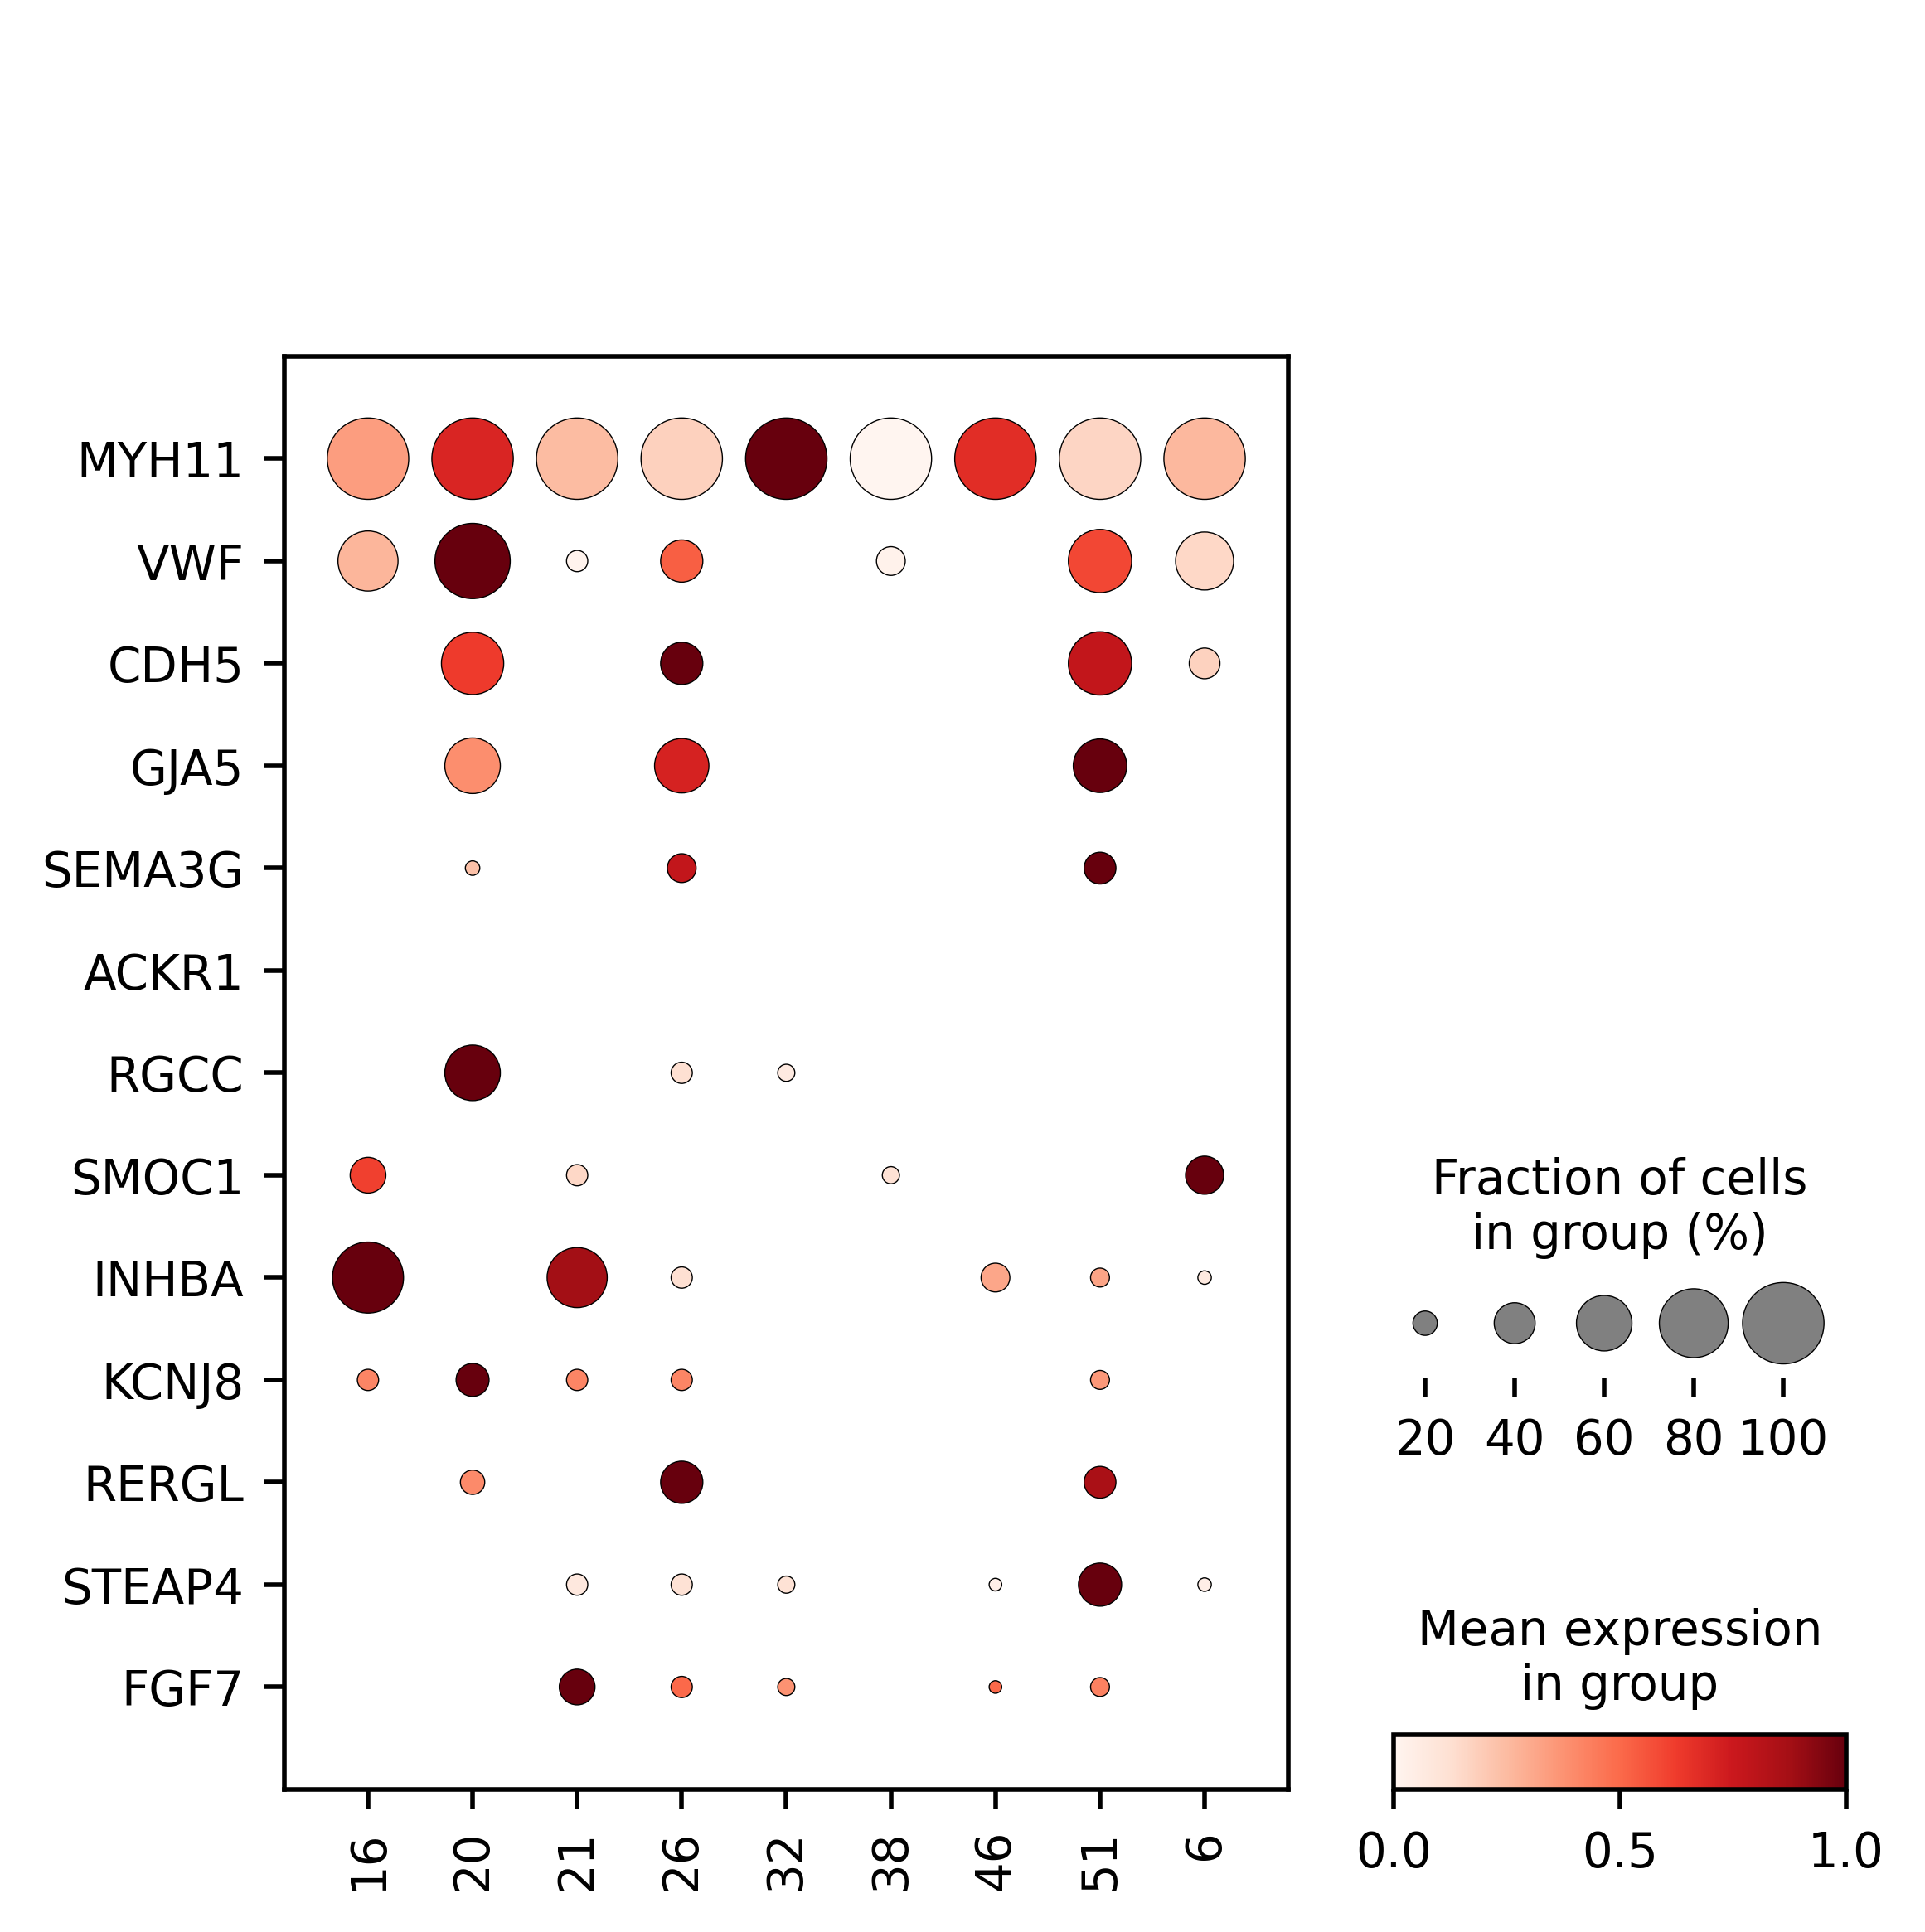

In [44]:
markers = ["MYH11","VWF","CDH5","GJA5","SEMA3G","ACKR1","RGCC","SMOC1","INHBA","KCNJ8","RERGL","STEAP4","FGF7"]
sc.pl.dotplot(adata_aec_subset, markers, "SMC_clusters", cmap = 'Reds', swap_axes = True, standard_scale = 'var')

In [45]:
#add vessel type annotation column

In [46]:
test["Vessel"] = ['Endocardium','Artery','Endocardium','Artery','Unclear','Endocardium','Endocardium','Artery','Endocardium']

In [47]:
test

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
16                 0.000000        0.000000      0.000000       0.166667   
20                 0.200000        0.000000      0.000000       0.300000   
21                 0.000000        0.166667      0.333333       0.166667   
26                 0.416667        0.166667      0.166667       0.166667   
32                 0.000000        0.125000      0.125000       0.000000   
38                 0.000000        0.000000      0.000000       0.000000   
46                 0.000000        0.083333      0.083333       0.000000   
51                 0.285714        0.428571      0.142857       0.142857   
6                  0.000000        0.090909      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
SMC_clusters                                                                  
16               0.333333             0.000000                   0.0    NaN   
20               0.700000             0.000000                   0.0    1.0   
21               0.000000             0.000000                   0.0    NaN   
26               0.750000             0.000000                   0.0    1.2   
32               0.000000             0.125000                   0.0    NaN   
38               0.125000             0.000000                   0.0    NaN   
46               0.166667             0.000000                   0.0    NaN   
51               0.571429             0.142857                   0.0    1.5   
6                0.000000             0.000000                   0.0    NaN   

              STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
SMC_clusters                                                                
16               NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
20               NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
21               1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
26               1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
32               2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
38               NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
46               1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
51               5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
6                1.0   NaN       NaN       NaN       NaN    NaN       NaN   

              SMOC1       Vessel  
SMC_clusters                      
16              2.0  Endocardium  
20              NaN       Artery  
21              1.0  Endocardium  
26              NaN       Artery  
32              NaN      Unclear  
38              1.0  Endocardium  
46              NaN  Endocardium  
51              NaN       Artery  
6               3.0  Endocardium

### add vessel size numbers

In [48]:
adata_aec_subset.obs.SMC_clusters.value_counts()

26    12
46    12
6     11
20    10
32     8
38     8
51     7
16     6
21     6
Name: SMC_clusters, dtype: int64

In [49]:
test2 = test.join(adata_aec_subset.obs['SMC_clusters'].value_counts(), on=None, how='left', lsuffix='', rsuffix='', sort=False, validate=None)

In [50]:
test2.columns = list(test2.columns[0:17]) + ['size']

In [51]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
16                 0.000000        0.000000      0.000000       0.166667   
20                 0.200000        0.000000      0.000000       0.300000   
21                 0.000000        0.166667      0.333333       0.166667   
26                 0.416667        0.166667      0.166667       0.166667   
32                 0.000000        0.125000      0.125000       0.000000   
38                 0.000000        0.000000      0.000000       0.000000   
46                 0.000000        0.083333      0.083333       0.000000   
51                 0.285714        0.428571      0.142857       0.142857   
6                  0.000000        0.090909      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
SMC_clusters                                                                  
16               0.333333             0.000000                   0.0    NaN   
20               0.700000             0.000000                   0.0    1.0   
21               0.000000             0.000000                   0.0    NaN   
26               0.750000             0.000000                   0.0    1.2   
32               0.000000             0.125000                   0.0    NaN   
38               0.125000             0.000000                   0.0    NaN   
46               0.166667             0.000000                   0.0    NaN   
51               0.571429             0.142857                   0.0    1.5   
6                0.000000             0.000000                   0.0    NaN   

              STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
SMC_clusters                                                                
16               NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
20               NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
21               1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
26               1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
32               2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
38               NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
46               1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
51               5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
6                1.0   NaN       NaN       NaN       NaN    NaN       NaN   

              SMOC1       Vessel  size  
SMC_clusters                            
16              2.0  Endocardium     6  
20              NaN       Artery    10  
21              1.0  Endocardium     6  
26              NaN       Artery    12  
32              NaN      Unclear     8  
38              1.0  Endocardium     8  
46              NaN  Endocardium    12  
51              NaN       Artery     7  
6               3.0  Endocardium    11

In [52]:
group=pd.Series("Large", index=test2.index)

In [53]:
group[test2["size"] <= 30] = "Small"

In [54]:
group

SMC_clusters
16    Small
20    Small
21    Small
26    Small
32    Small
38    Small
46    Small
51    Small
6     Small
dtype: object

In [55]:
test2["group"] = group

In [56]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
16                 0.000000        0.000000      0.000000       0.166667   
20                 0.200000        0.000000      0.000000       0.300000   
21                 0.000000        0.166667      0.333333       0.166667   
26                 0.416667        0.166667      0.166667       0.166667   
32                 0.000000        0.125000      0.125000       0.000000   
38                 0.000000        0.000000      0.000000       0.000000   
46                 0.000000        0.083333      0.083333       0.000000   
51                 0.285714        0.428571      0.142857       0.142857   
6                  0.000000        0.090909      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
SMC_clusters                                                                  
16               0.333333             0.000000                   0.0    NaN   
20               0.700000             0.000000                   0.0    1.0   
21               0.000000             0.000000                   0.0    NaN   
26               0.750000             0.000000                   0.0    1.2   
32               0.000000             0.125000                   0.0    NaN   
38               0.125000             0.000000                   0.0    NaN   
46               0.166667             0.000000                   0.0    NaN   
51               0.571429             0.142857                   0.0    1.5   
6                0.000000             0.000000                   0.0    NaN   

              STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
SMC_clusters                                                                
16               NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
20               NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
21               1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
26               1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
32               2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
38               NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
46               1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
51               5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
6                1.0   NaN       NaN       NaN       NaN    NaN       NaN   

              SMOC1       Vessel  size  group  
SMC_clusters                                   
16              2.0  Endocardium     6  Small  
20              NaN       Artery    10  Small  
21              1.0  Endocardium     6  Small  
26              NaN       Artery    12  Small  
32              NaN      Unclear     8  Small  
38              1.0  Endocardium     8  Small  
46              NaN  Endocardium    12  Small  
51              NaN       Artery     7  Small  
6               3.0  Endocardium    11  Small

In [57]:
test2["vessel_size"] = test2["Vessel"] + "_" + test2["group"]

In [58]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
16                 0.000000        0.000000      0.000000       0.166667   
20                 0.200000        0.000000      0.000000       0.300000   
21                 0.000000        0.166667      0.333333       0.166667   
26                 0.416667        0.166667      0.166667       0.166667   
32                 0.000000        0.125000      0.125000       0.000000   
38                 0.000000        0.000000      0.000000       0.000000   
46                 0.000000        0.083333      0.083333       0.000000   
51                 0.285714        0.428571      0.142857       0.142857   
6                  0.000000        0.090909      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
SMC_clusters                                                                  
16               0.333333             0.000000                   0.0    NaN   
20               0.700000             0.000000                   0.0    1.0   
21               0.000000             0.000000                   0.0    NaN   
26               0.750000             0.000000                   0.0    1.2   
32               0.000000             0.125000                   0.0    NaN   
38               0.125000             0.000000                   0.0    NaN   
46               0.166667             0.000000                   0.0    NaN   
51               0.571429             0.142857                   0.0    1.5   
6                0.000000             0.000000                   0.0    NaN   

              STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
SMC_clusters                                                                
16               NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
20               NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
21               1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
26               1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
32               2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
38               NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
46               1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
51               5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
6                1.0   NaN       NaN       NaN       NaN    NaN       NaN   

              SMOC1       Vessel  size  group        vessel_size  
SMC_clusters                                                      
16              2.0  Endocardium     6  Small  Endocardium_Small  
20              NaN       Artery    10  Small       Artery_Small  
21              1.0  Endocardium     6  Small  Endocardium_Small  
26              NaN       Artery    12  Small       Artery_Small  
32              NaN      Unclear     8  Small      Unclear_Small  
38              1.0  Endocardium     8  Small  Endocardium_Small  
46              NaN  Endocardium    12  Small  Endocardium_Small  
51              NaN       Artery     7  Small       Artery_Small  
6               3.0  Endocardium    11  Small  Endocardium_Small

In [59]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### add ROI numbers

In [60]:
test2.index = ['ROI_A2-3_' + str(i) for i in test2.index.tolist()]

In [61]:
test2["ROI"] = "A2-3"

In [62]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
ROI_A2-3_16       0.000000        0.000000      0.000000       0.166667   
ROI_A2-3_20       0.200000        0.000000      0.000000       0.300000   
ROI_A2-3_21       0.000000        0.166667      0.333333       0.166667   
ROI_A2-3_26       0.416667        0.166667      0.166667       0.166667   
ROI_A2-3_32       0.000000        0.125000      0.125000       0.000000   
ROI_A2-3_38       0.000000        0.000000      0.000000       0.000000   
ROI_A2-3_46       0.000000        0.083333      0.083333       0.000000   
ROI_A2-3_51       0.285714        0.428571      0.142857       0.142857   
ROI_A2-3_6        0.000000        0.090909      0.000000       0.000000   

             AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
ROI_A2-3_16     0.333333             0.000000                   0.0    NaN   
ROI_A2-3_20     0.700000             0.000000                   0.0    1.0   
ROI_A2-3_21     0.000000             0.000000                   0.0    NaN   
ROI_A2-3_26     0.750000             0.000000                   0.0    1.2   
ROI_A2-3_32     0.000000             0.125000                   0.0    NaN   
ROI_A2-3_38     0.125000             0.000000                   0.0    NaN   
ROI_A2-3_46     0.166667             0.000000                   0.0    NaN   
ROI_A2-3_51     0.571429             0.142857                   0.0    1.5   
ROI_A2-3_6      0.000000             0.000000                   0.0    NaN   

             STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
ROI_A2-3_16     NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
ROI_A2-3_20     NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
ROI_A2-3_21     1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
ROI_A2-3_26     1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
ROI_A2-3_32     2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
ROI_A2-3_38     NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
ROI_A2-3_46     1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
ROI_A2-3_51     5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
ROI_A2-3_6      1.0   NaN       NaN       NaN       NaN    NaN       NaN   

             SMOC1       Vessel  size  group        vessel_size   ROI  
ROI_A2-3_16    2.0  Endocardium     6  Small  Endocardium_Small  A2-3  
ROI_A2-3_20    NaN       Artery    10  Small       Artery_Small  A2-3  
ROI_A2-3_21    1.0  Endocardium     6  Small  Endocardium_Small  A2-3  
ROI_A2-3_26    NaN       Artery    12  Small       Artery_Small  A2-3  
ROI_A2-3_32    NaN      Unclear     8  Small      Unclear_Small  A2-3  
ROI_A2-3_38    1.0  Endocardium     8  Small  Endocardium_Small  A2-3  
ROI_A2-3_46    NaN  Endocardium    12  Small  Endocardium_Small  A2-3  
ROI_A2-3_51    NaN       Artery     7  Small       Artery_Small  A2-3  
ROI_A2-3_6     3.0  Endocardium    11  Small  Endocardium_Small  A2-3

[Text(0.5, 1.0, 'RERGL percentage expression')]

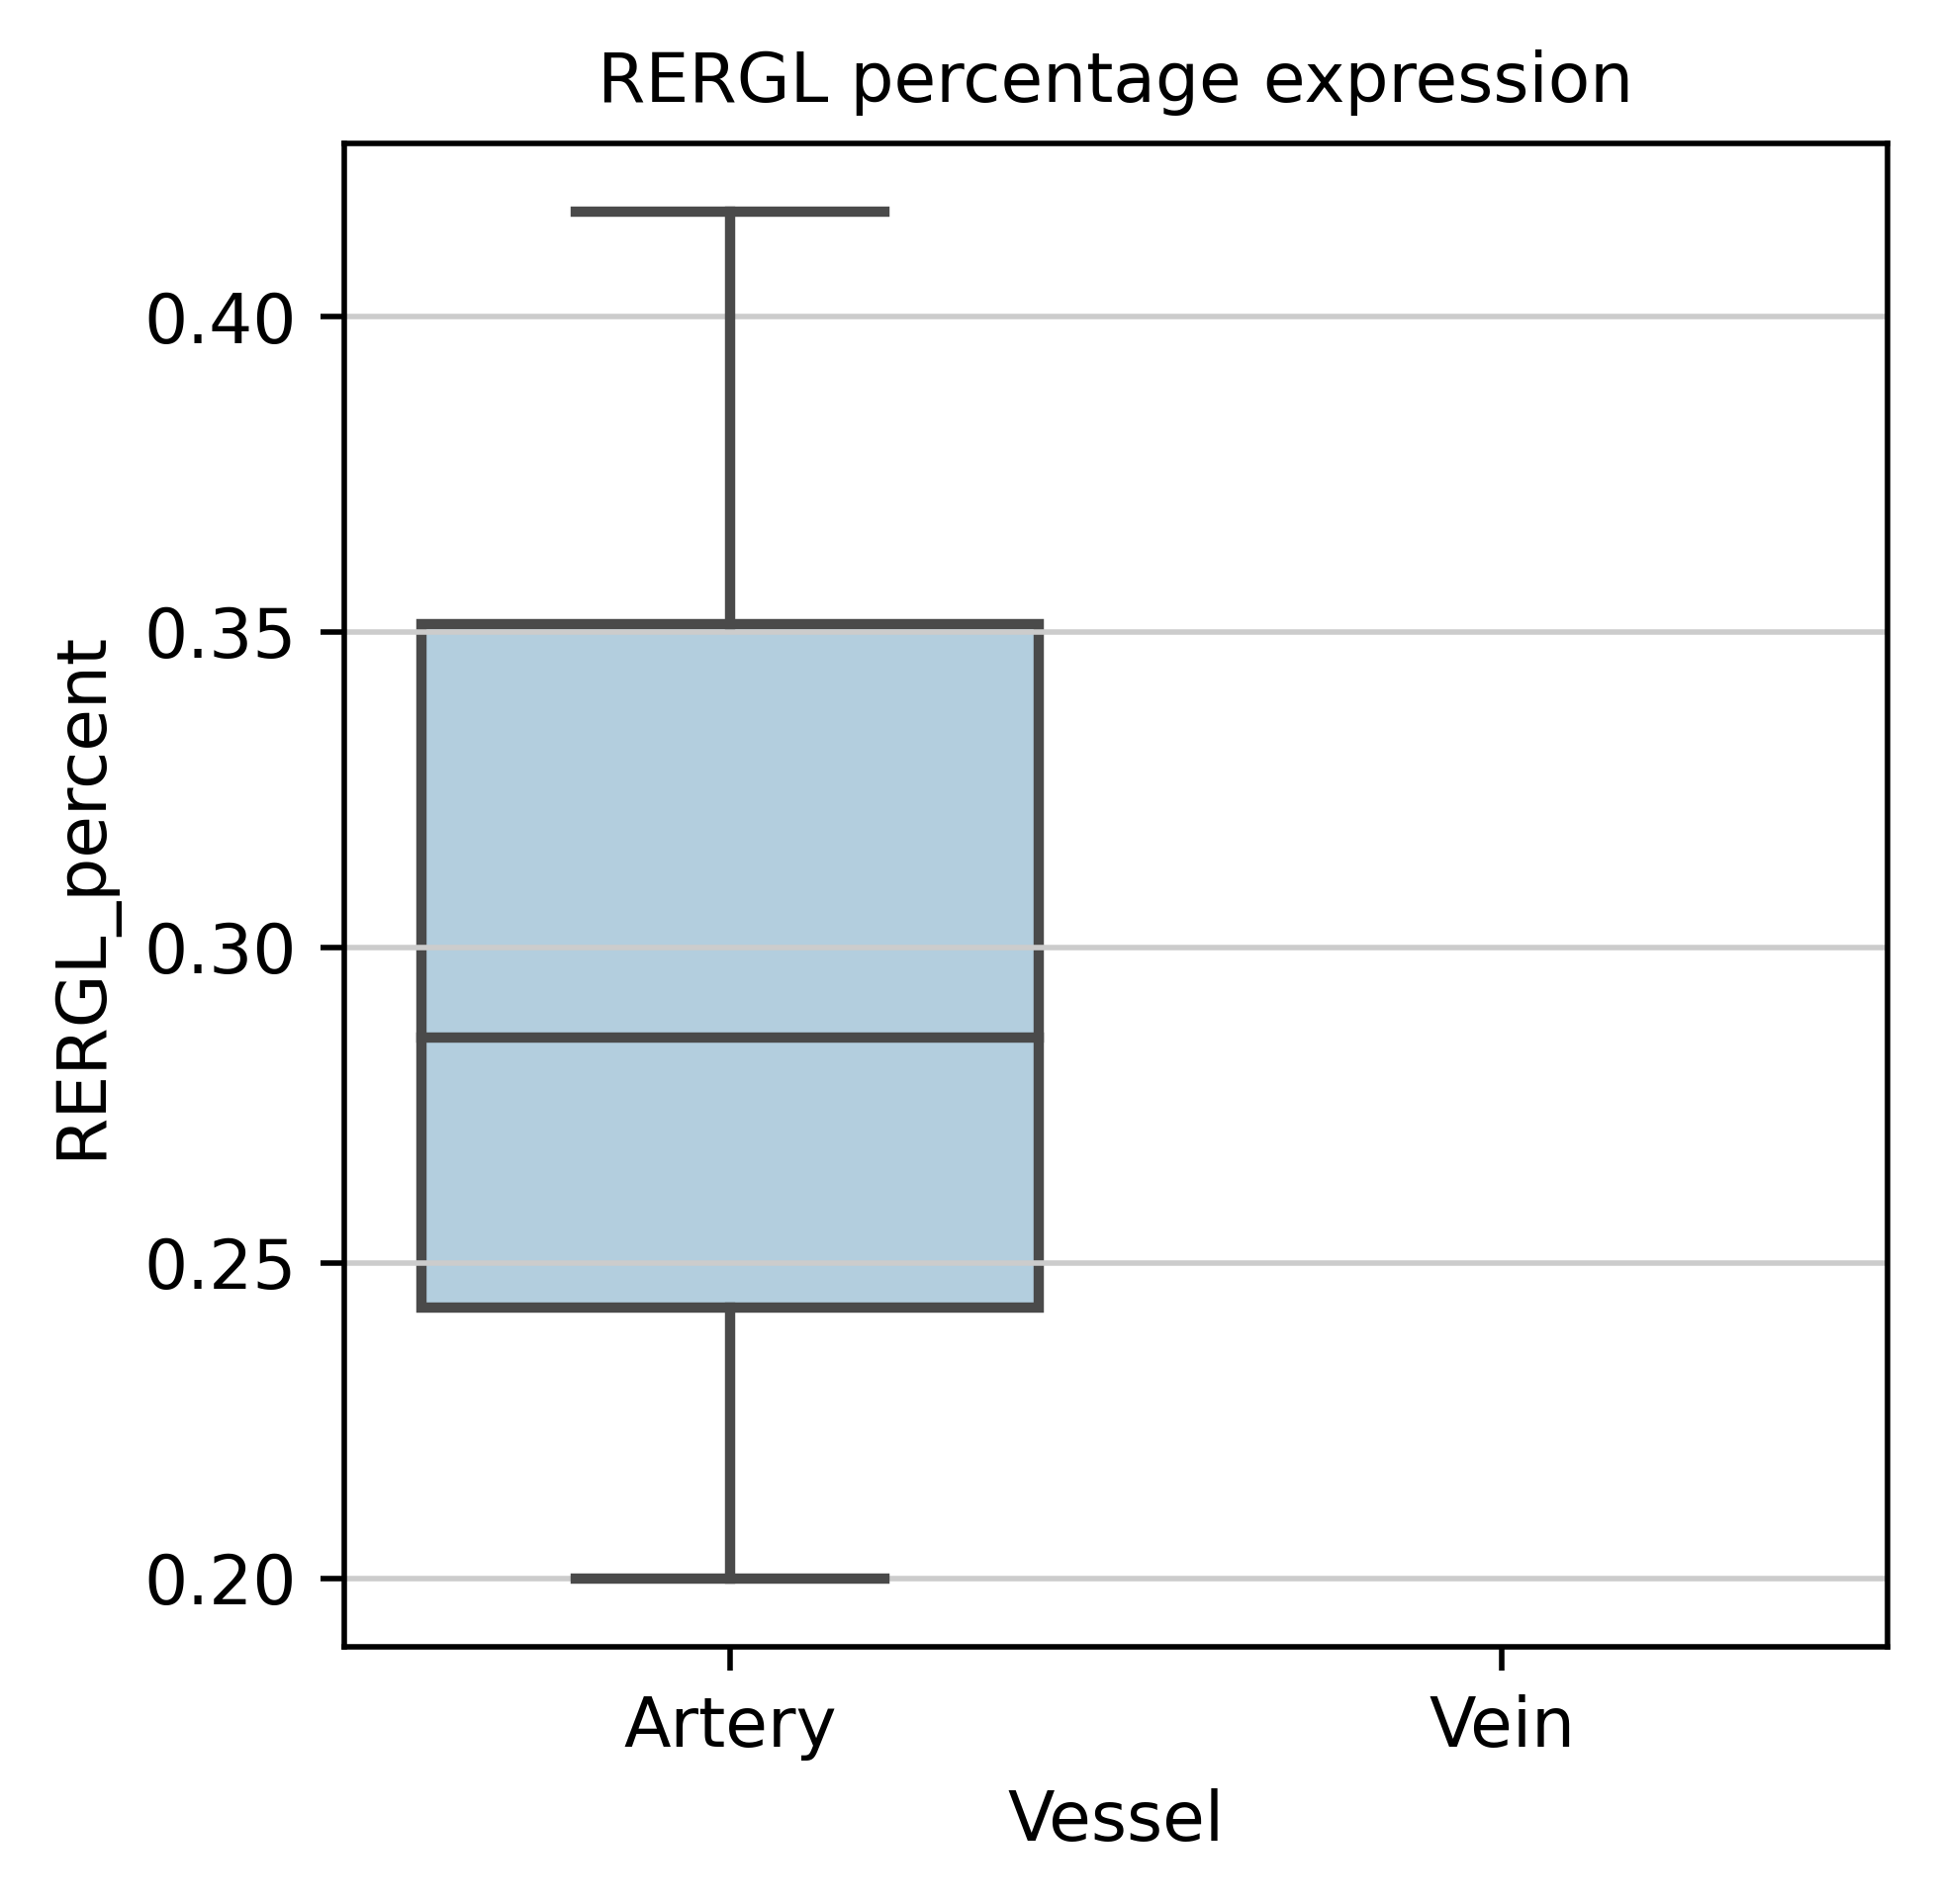

In [63]:
sns.boxplot(data = test, x = "Vessel", y = "RERGL_percent", palette = 'Blues', order = ['Artery','Vein']).set(title='RERGL percentage expression')

[Text(0.5, 1.0, 'RERGL mean expression')]

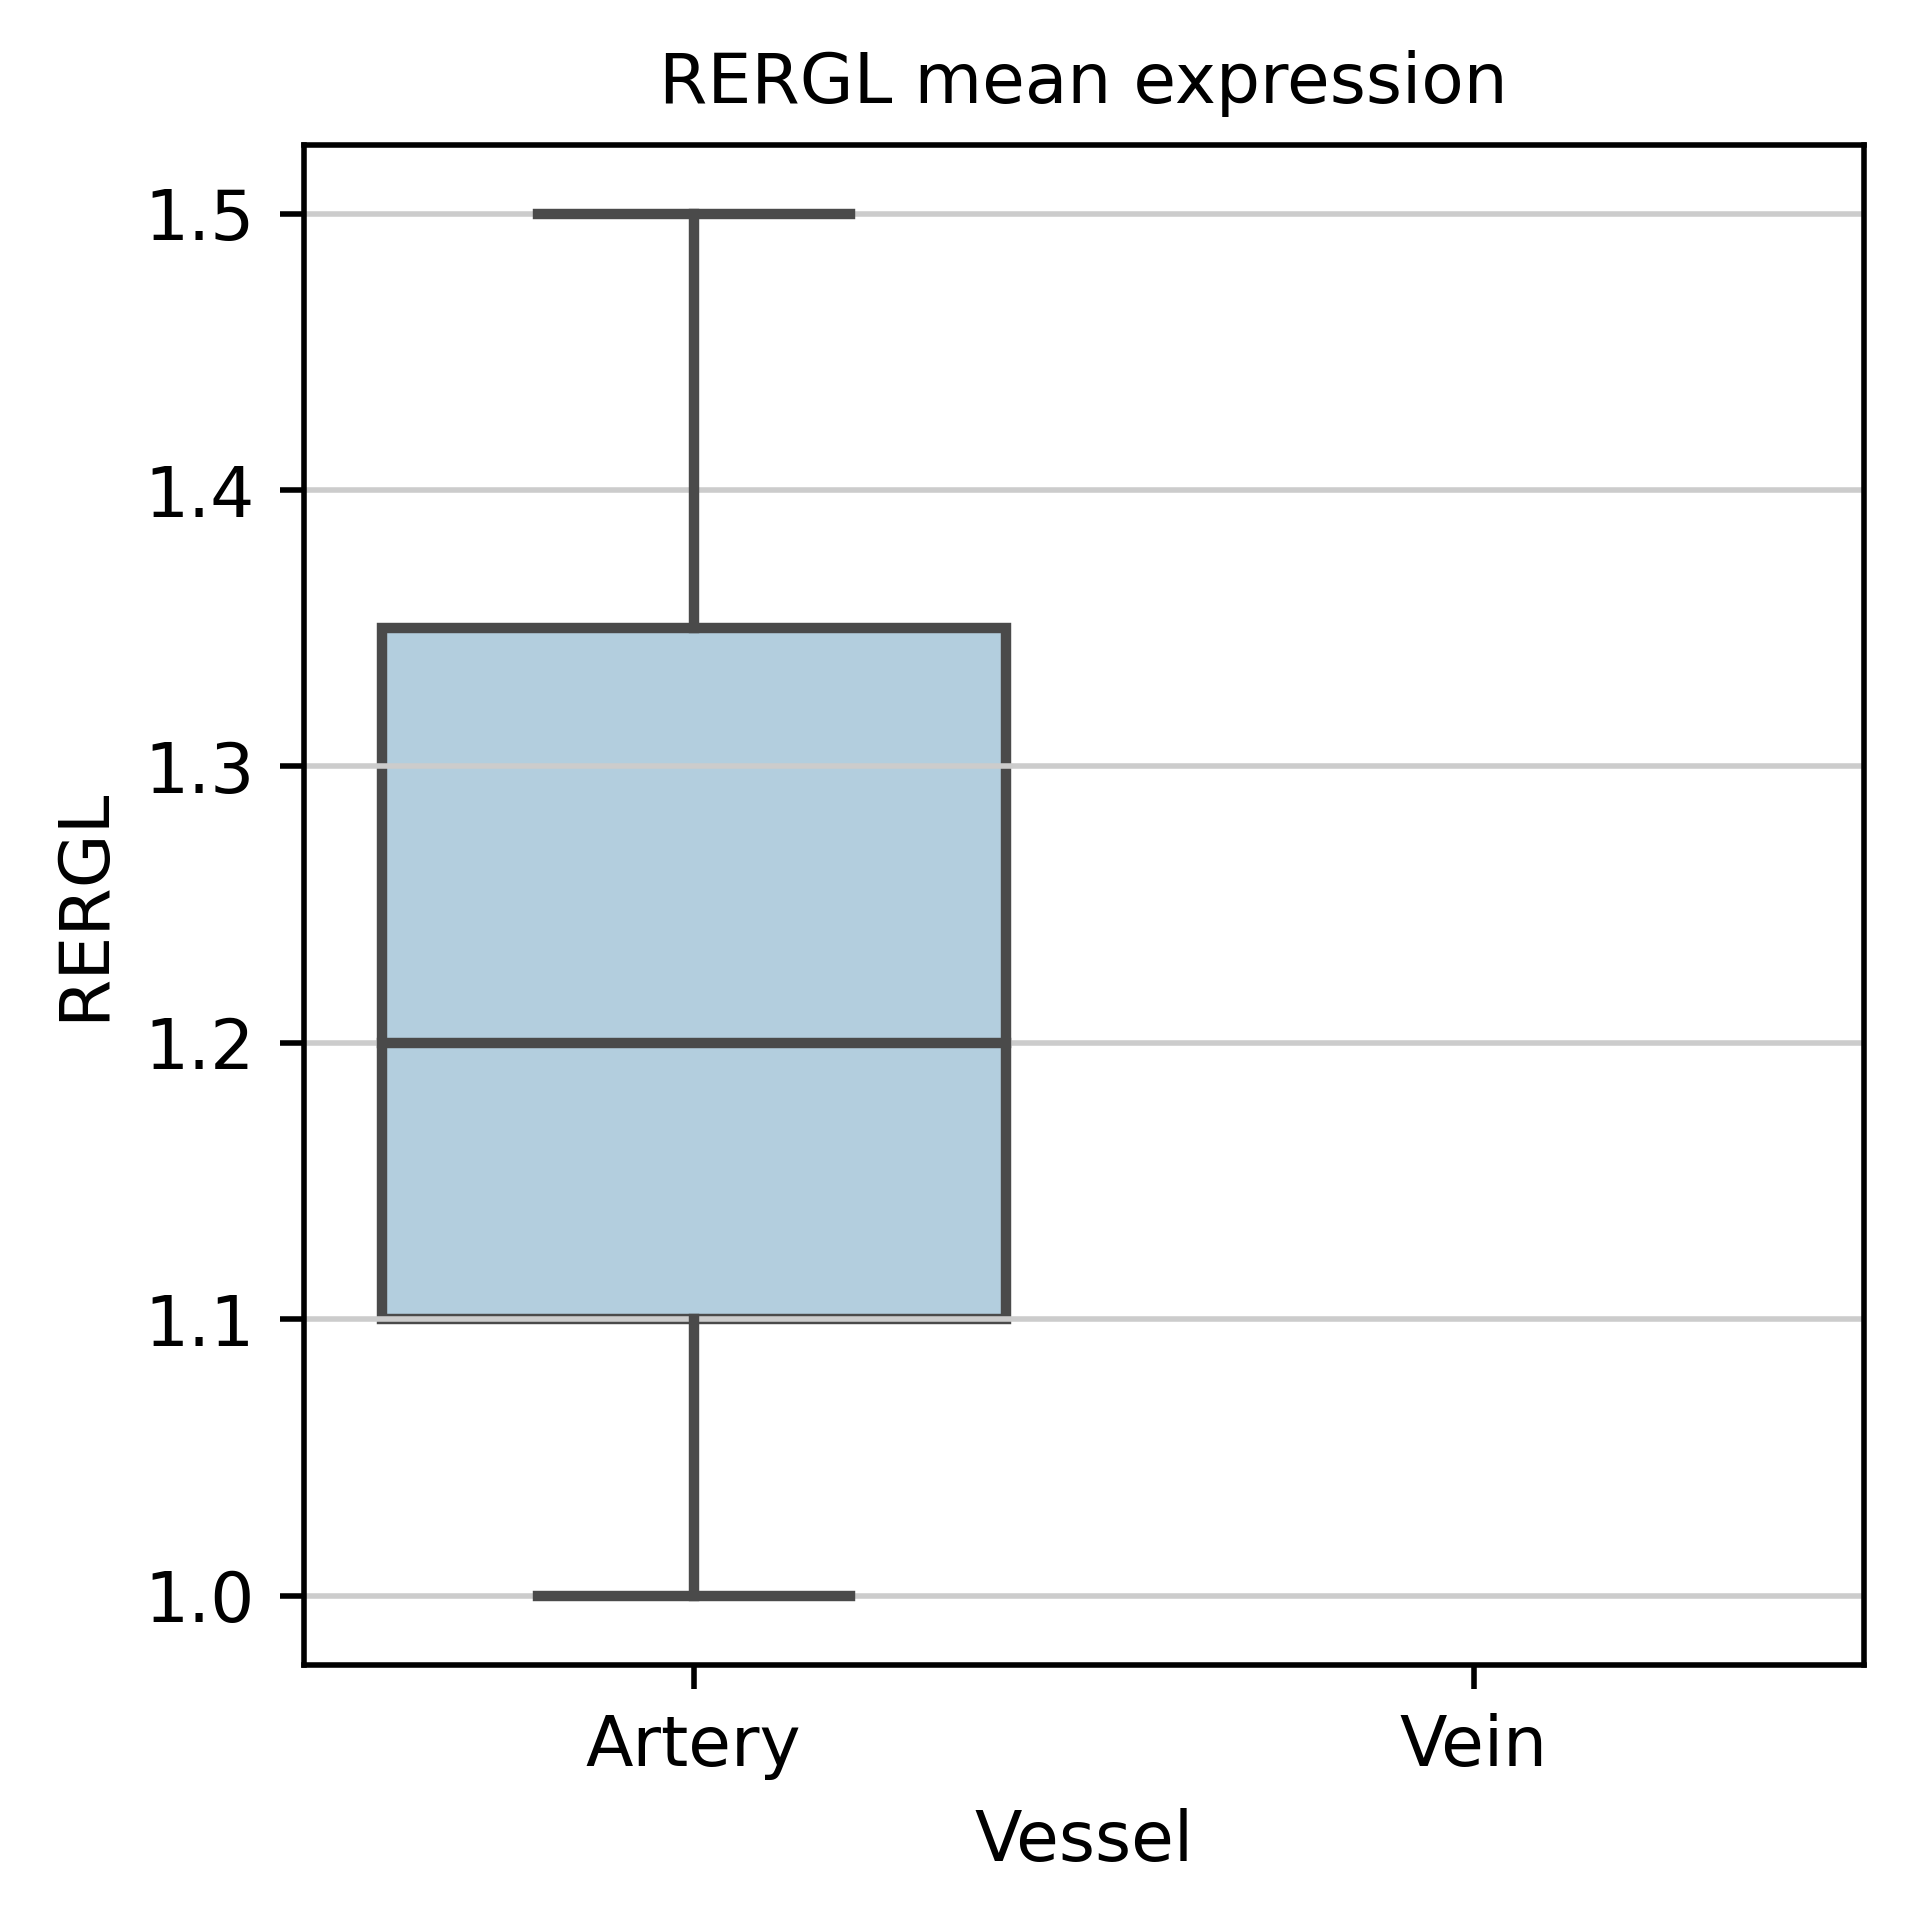

In [64]:
sns.boxplot(data = test, x = "Vessel", y = "RERGL", palette = 'Blues', order = ['Artery','Vein']).set(title='RERGL mean expression')

[Text(0.5, 1.0, 'STEAP4 percentage expression')]

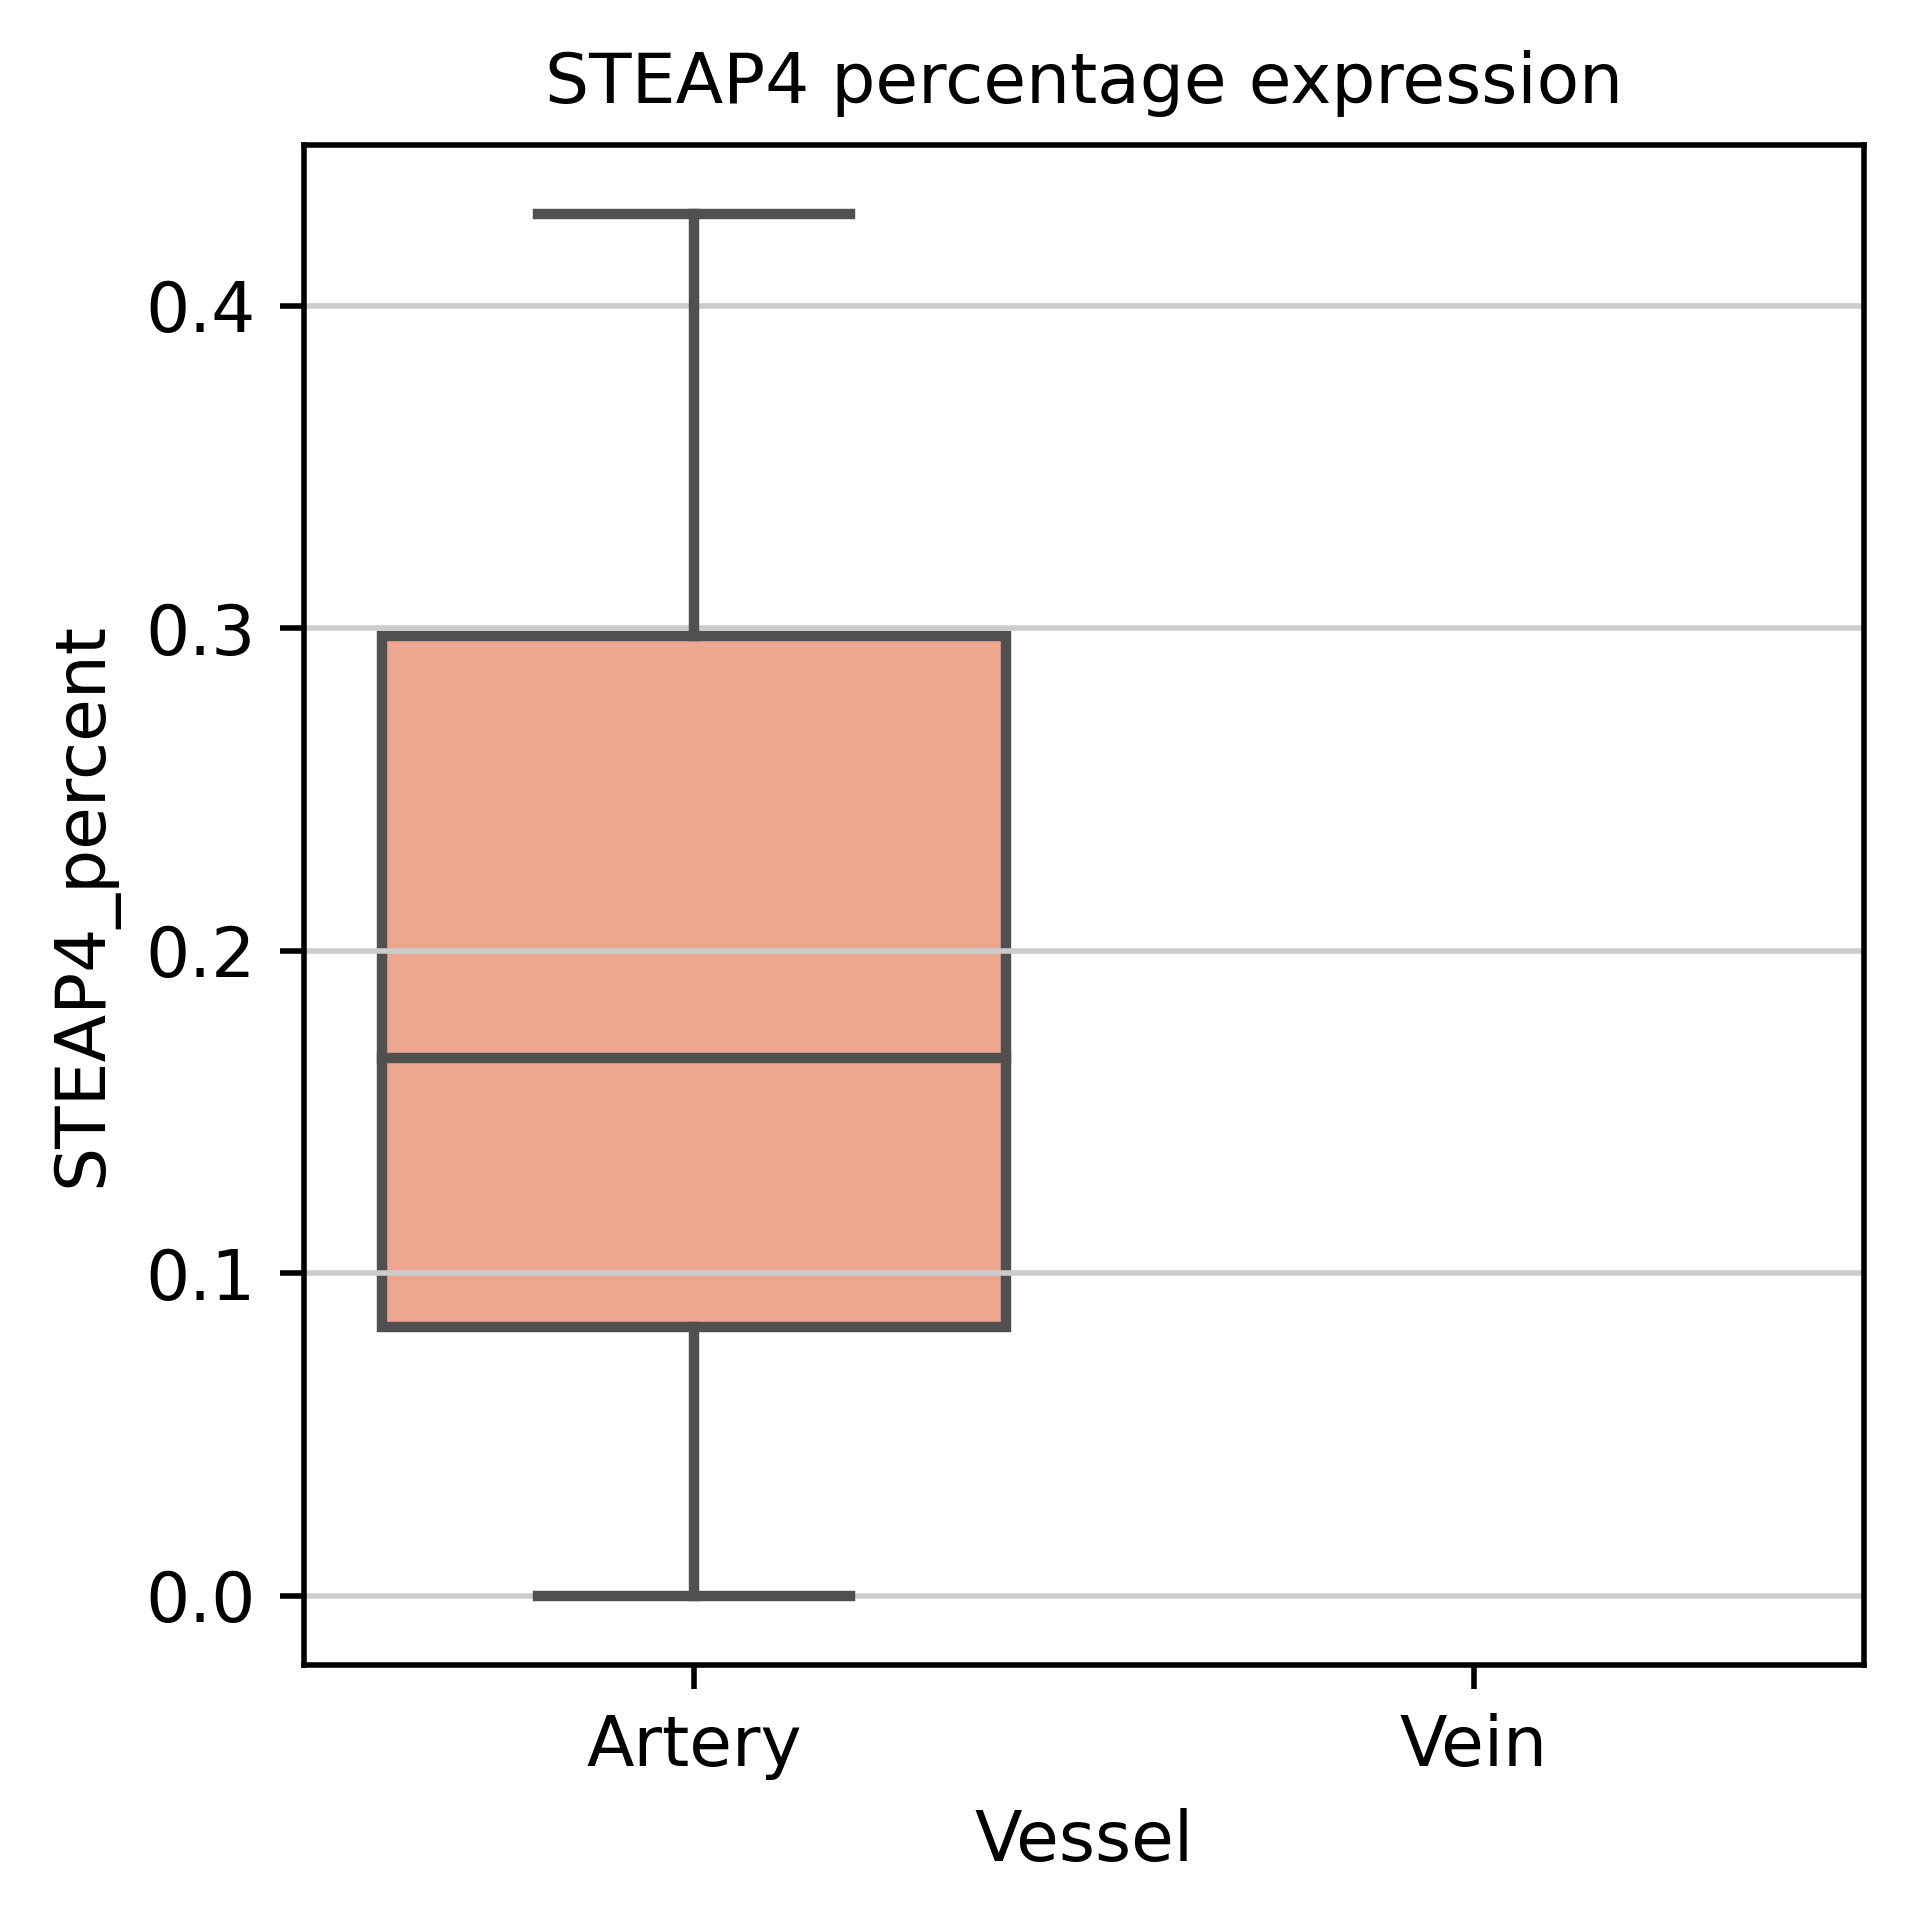

In [65]:
sns.boxplot(data = test, x = "Vessel", y = "STEAP4_percent", palette = 'Reds', order = ['Artery','Vein']).set(title='STEAP4 percentage expression')

[Text(0.5, 1.0, 'STEAP4 mean expression')]

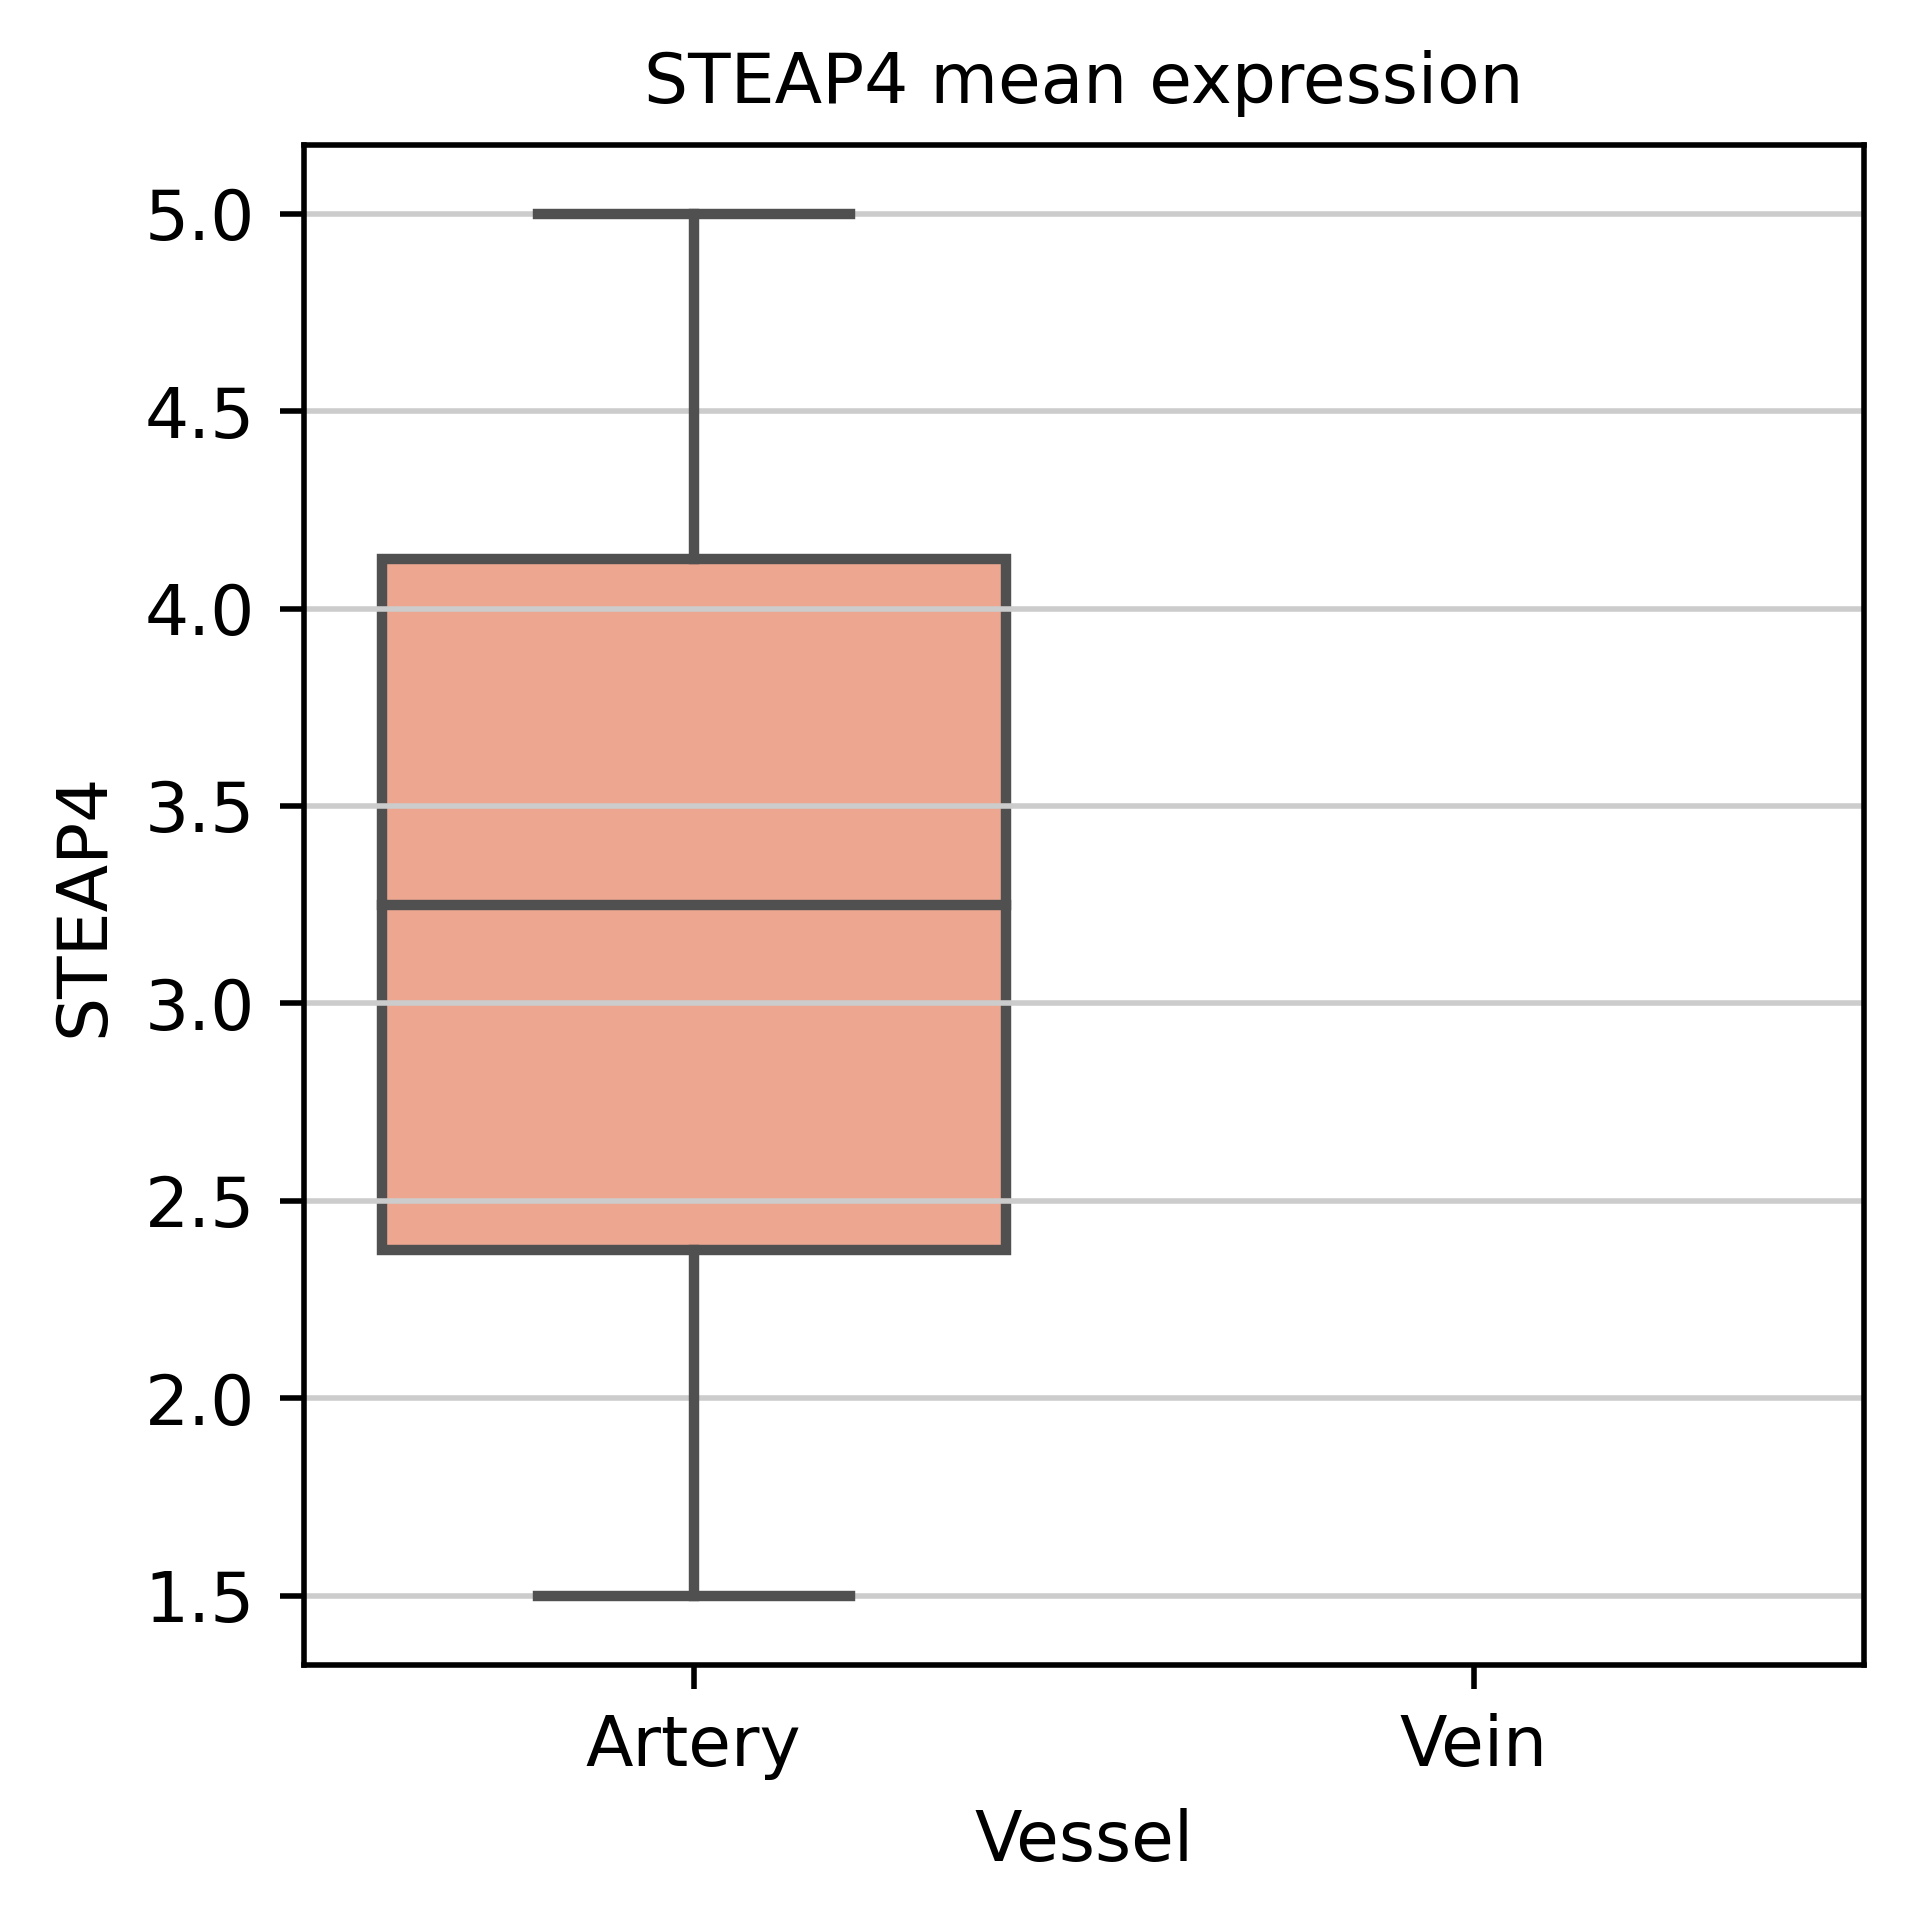

In [66]:
sns.boxplot(data = test, x = "Vessel", y = "STEAP4", palette = 'Reds', order = ['Artery','Vein']).set(title='STEAP4 mean expression')

In [67]:
test

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
ROI_A2-3_16       0.000000        0.000000      0.000000       0.166667   
ROI_A2-3_20       0.200000        0.000000      0.000000       0.300000   
ROI_A2-3_21       0.000000        0.166667      0.333333       0.166667   
ROI_A2-3_26       0.416667        0.166667      0.166667       0.166667   
ROI_A2-3_32       0.000000        0.125000      0.125000       0.000000   
ROI_A2-3_38       0.000000        0.000000      0.000000       0.000000   
ROI_A2-3_46       0.000000        0.083333      0.083333       0.000000   
ROI_A2-3_51       0.285714        0.428571      0.142857       0.142857   
ROI_A2-3_6        0.000000        0.090909      0.000000       0.000000   

             AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  RERGL  \
ROI_A2-3_16     0.333333             0.000000                   0.0    NaN   
ROI_A2-3_20     0.700000             0.000000                   0.0    1.0   
ROI_A2-3_21     0.000000             0.000000                   0.0    NaN   
ROI_A2-3_26     0.750000             0.000000                   0.0    1.2   
ROI_A2-3_32     0.000000             0.125000                   0.0    NaN   
ROI_A2-3_38     0.125000             0.000000                   0.0    NaN   
ROI_A2-3_46     0.166667             0.000000                   0.0    NaN   
ROI_A2-3_51     0.571429             0.142857                   0.0    1.5   
ROI_A2-3_6      0.000000             0.000000                   0.0    NaN   

             STEAP4  FGF7       AGT     KCNJ8    SEMA3G  ACKR1      RGCC  \
ROI_A2-3_16     NaN   NaN  1.000000  1.000000       NaN    NaN       NaN   
ROI_A2-3_20     NaN   NaN  2.857143  1.333333  1.000000    NaN  3.333333   
ROI_A2-3_21     1.0   1.0       NaN  1.000000       NaN    NaN       NaN   
ROI_A2-3_26     1.5   1.0  9.888889  1.000000  1.333333    NaN  1.500000   
ROI_A2-3_32     2.0   1.0       NaN       NaN       NaN    NaN  1.000000   
ROI_A2-3_38     NaN   NaN  2.000000       NaN       NaN    NaN       NaN   
ROI_A2-3_46     1.0   2.0  1.000000       NaN       NaN    NaN       NaN   
ROI_A2-3_51     5.0   1.0  9.250000  1.000000  1.500000    NaN       NaN   
ROI_A2-3_6      1.0   NaN       NaN       NaN       NaN    NaN       NaN   

             SMOC1       Vessel   ROI  
ROI_A2-3_16    2.0  Endocardium  A2-3  
ROI_A2-3_20    NaN       Artery  A2-3  
ROI_A2-3_21    1.0  Endocardium  A2-3  
ROI_A2-3_26    NaN       Artery  A2-3  
ROI_A2-3_32    NaN      Unclear  A2-3  
ROI_A2-3_38    1.0  Endocardium  A2-3  
ROI_A2-3_46    NaN  Endocardium  A2-3  
ROI_A2-3_51    NaN       Artery  A2-3  
ROI_A2-3_6     3.0  Endocardium  A2-3